# Weight-Loss Medications & Diabetes Risk: Exploratory Data Analysis

This notebook explores two complementary datasets:

1. **glp1_weight_loss_medications_dispensing_2019_2023.csv**  
   Monthly dispensing of GLP-1 and related weight-loss/diabetes medications (e.g., Ozempic, Saxenda, Victoza) by a UK pharmacy.

2. **diabetes_health_indicators_patientlevel_synthetic.csv**  
   A large, synthetic but clinically realistic patient-level dataset with demographic, lifestyle, clinical and diabetes outcome variables.

The goals are to:

- Perform a **structured Exploratory Data Analysis (EDA)** on both datasets.
- Apply **supervised learning** (linear and logistic regression) to quantify relationships.
- Use **clear, accessible visualisations** and explain results in plain language.
- Link **population-level risk** with **pharmacological response** (GLP-1 prescribing trends).

The notebook is written to be understandable for both technical and clinical audiences.

In [57]:
# 1. Setup (Colab-friendly)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

sns.set_theme(style="whitegrid", context="notebook")
sns.set_palette("colorblind")

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["figure.autolayout"] = True

## 1.1 Accessibility choices

- **Colour palette:** `colorblind` to support colour-vision deficiencies.
- **Font sizes:** increased to reduce visual fatigue.
- **Gridlines:** light gridlines for easier value tracking.
- **Plain-language captions:** short, specific explanations after key plots.
- **Consistent formatting:** same axes labels and units across comparable charts.

In [58]:
# 2. Load data

medications_path = "glp1_weight_loss_medications_dispensing_2019_2023.csv"
diabetes_path = "diabetes_health_indicators_patientlevel_synthetic.csv"

df_med = pd.read_csv(medications_path)
df_diab = pd.read_csv(diabetes_path)

print("Medications dataset shape:", df_med.shape)
print("Diabetes dataset shape   :", df_diab.shape)

print("\nMedications columns:\n", df_med.columns.tolist())
print("\nDiabetes columns:\n", df_diab.columns.tolist())

Medications dataset shape: (391, 8)
Diabetes dataset shape   : (97297, 31)

Medications columns:
 ['Year Month', 'Prescribed BNF Presentation Code', 'Prescribed BNF Presentation', 'BNF Chemical Substance', 'Dispensed (Reimbursed) BNF Presentation Code', 'Dispensed (Reimbursed) BNF Presentation', 'Items', 'Total Quantity']

Diabetes columns:
 ['Age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score', 'diabetes_stage', 'diagnosed_diabetes']


We work with two different granularities:

- **Medication dataset (`df_med`)**: monthly dispensing records.
- **Diabetes dataset (`df_diab`)**: one row per individual with risk factors and outcomes.

In [59]:
# 3. Structure & data types

print("Medications info:")
df_med.info()

print("\nDiabetes info:")
df_diab.info()

Medications info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Year Month                                    391 non-null    int64 
 1   Prescribed BNF Presentation Code              391 non-null    object
 2   Prescribed BNF Presentation                   391 non-null    object
 3   BNF Chemical Substance                        391 non-null    object
 4   Dispensed (Reimbursed) BNF Presentation Code  391 non-null    object
 5   Dispensed (Reimbursed) BNF Presentation       391 non-null    object
 6   Items                                         391 non-null    int64 
 7   Total Quantity                                391 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 24.6+ KB

Diabetes info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97297 entries, 0 to 9

## 3.1 Variable types overview

Classifying variables helps decide:
- which summary statistics are meaningful,
- which plots are appropriate,
- which models can be applied.

Typical categories in this notebook:

- **Numeric continuous (patient-level):** age, BMI, waist-to-hip ratio, blood pressure, lipids (total/HDL/LDL cholesterol, triglycerides), glycaemic markers (fasting/postprandial glucose, HbA1c), insulin, and diabetes risk score.
- **Numeric discrete (dispensing):** items, total_quantity.
- **Categorical nominal (patient-level):** gender, ethnicity, education_level, income_level, employment_status, smoking_status, diabetes_stage.
- **Categorical nominal (dispensing):** chemical_substance, prescribed_presentation, dispensed_presentation, commercial_name.
- **Categorical ordinal (engineered):** BMI category, activity level, age band.
- **Binary (patient history / outcomes):** diagnosed_diabetes, family_history_diabetes, hypertension_history, cardiovascular_history.

In [60]:
# 4. Data cleaning & feature engineering

# 4.1 Medications: parse "Year Month" (YYYYMM) -> date + components
date_col = "Year Month"
df_med["year_month_raw"] = df_med[date_col].astype(float).astype(int)
df_med["date"] = pd.to_datetime(df_med["year_month_raw"].astype(str), format="%Y%m")

df_med["year"] = df_med["date"].dt.year
df_med["month"] = df_med["date"].dt.month
df_med["month_name"] = df_med["date"].dt.month_name()
df_med = df_med.sort_values("date")

# Check complete monthly coverage
full_months = pd.date_range(start=df_med["date"].min(), end=df_med["date"].max(), freq="MS")
missing_months = sorted(set(full_months) - set(df_med["date"].unique()))

print("First date:", df_med["date"].min().date())
print("Last date :", df_med["date"].max().date())
print("Expected months:", len(full_months))
print("Observed months:", df_med["date"].nunique())
print("Missing months:", missing_months[:12], "..." if len(missing_months) > 12 else "")

First date: 2019-01-01
Last date : 2023-08-01
Expected months: 56
Observed months: 56
Missing months: [] 


In [61]:
# Standardise column names if present, including your added Commercial Name column
df_med = df_med.rename(columns={
    "BNF Chemical Substance": "chemical_substance",
    "Prescribed BNF Presentation": "prescribed_presentation",
    "Dispensed (Reimbursed) BNF Presentation": "dispensed_presentation",
    "Items": "items",
    "Total Quantity": "total_quantity",
    "Commercial Name": "commercial_name"
})

df_med.head()

Year Month Prescribed BNF Presentation Code  \
0      201901                  0601023ABAAAAAA   
1      201901                  0601023ABBBAAAA   
2      201902                  0601023ABAAAAAA   
3      201902                  0601023ABBBAAAA   
4      201903                  0601023ABAAAAAA   

                             prescribed_presentation chemical_substance  \
0  Liraglutide 6mg/1ml inj 3ml pre-filled disposa...        Liraglutide   
1  Victoza 6mg/ml solution for injection 3ml pre-...        Liraglutide   
2  Liraglutide 6mg/1ml inj 3ml pre-filled disposa...        Liraglutide   
3  Victoza 6mg/ml solution for injection 3ml pre-...        Liraglutide   
4  Liraglutide 6mg/1ml inj 3ml pre-filled disposa...        Liraglutide   

  Dispensed (Reimbursed) BNF Presentation Code  \
0                              0601023ABBBAAAA   
1                              0601023ABBBAAAA   
2                              0601023ABBBAAAA   
3                              0601023ABBBAAAA   
4                              0601023ABBBAAAA   

                              dispensed_presentation  items  total_quantity  \
0  Victoza 6mg/ml solution for injection 3ml pre-...     13              35   
1  Victoza 6mg/ml solution for injection 3ml pre-...      8              18   
2  Victoza 6mg/ml solution for injection 3ml pre-...     13              32   
3  Victoza 6mg/ml solution for injection 3ml pre-...      7              15   
4  Victoza 6mg/ml solution for injection 3ml pre-...     11              28   

   year_month_raw       date  year  month month_name  
0          201901 2019-01-01  2019      1    January  
1          201901 2019-01-01  2019      1    January  
2          201902 2019-02-01  2019      2   February  
3          201902 2019-02-01  2019      2   February  
4          201903 2019-03-01  2019      3      March

### 4.1.1 About `commercial_name`

`commercial_name` is useful for non-medical readers, but the clinically stable analysis unit is often the **active molecule** (`chemical_substance`).  
A quick sanity check ensures commercial names are not ambiguously mapped to multiple molecules.

In [62]:
if {"commercial_name", "chemical_substance"}.issubset(df_med.columns):
    mapping_check = (
        df_med.groupby("commercial_name")["chemical_substance"]
        .nunique()
        .sort_values(ascending=False)
    )
    display(mapping_check.head(25))

In [63]:
# 4.2 Diabetes dataset: derived features (only if columns exist)

def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    elif bmi < 35:
        return "Obesity I"
    elif bmi < 40:
        return "Obesity II"
    else:
        return "Obesity III"

if "bmi" in df_diab.columns:
    df_diab["bmi_category"] = df_diab["bmi"].apply(bmi_category)

if "physical_activity_minutes_per_week" in df_diab.columns:
    def activity_level(minutes):
        if minutes < 60:
            return "Low"
        elif minutes < 150:
            return "Moderate"
        else:
            return "High"
    df_diab["activity_level"] = df_diab["physical_activity_minutes_per_week"].apply(activity_level)

if "age" in df_diab.columns:
    age_bins = [18, 30, 40, 50, 60, 70, 80, 120]
    age_labels = ["18–29", "30–39", "40–49", "50–59", "60–69", "70–79", "80+"]
    df_diab["age_band"] = pd.cut(df_diab["age"], bins=age_bins, labels=age_labels, right=False)

for col in ["gender", "diabetes_stage"]:
    if col in df_diab.columns:
        df_diab[col] = df_diab[col].astype("category")

for col in ["diagnosed_diabetes", "family_history_diabetes", "hypertension_history"]:
    if col in df_diab.columns:
        df_diab[col] = df_diab[col].astype(int)

df_diab.head()

Age  gender ethnicity education_level  income_level employment_status  \
0   58    Male     Asian      Highschool  Lower-Middle          Employed   
1   52  Female     White      Highschool        Middle          Employed   
2   60    Male  Hispanic      Highschool        Middle        Unemployed   
3   74  Female     Black      Highschool           Low           Retired   
4   46    Male     White        Graduate        Middle           Retired   

  smoking_status  alcohol_consumption_per_week  \
0          Never                             0   
1         Former                             1   
2          Never                             1   
3          Never                             0   
4          Never                             1   

   physical_activity_minutes_per_week  diet_score  sleep_hours_per_day  \
0                                 215        5.70                 7.90   
1                                 143        6.70                 6.50   
2                                  57        6.40                10.00   
3                                  49        3.40                 6.60   
4                                 109        7.20                 7.40   

   screen_time_hours_per_day  family_history_diabetes  hypertension_history  \
0                       7.90                        0                     0   
1                       8.70                        0                     0   
2                       8.10                        1                     0   
3                       5.20                        0                     0   
4                       5.00                        0                     0   

   cardiovascular_history   bmi  waist_to_hip_ratio  systolic_bp  \
0                       0 30.50                0.89          134   
1                       0 23.10                0.80          129   
2                       0 22.20                0.81          115   
3                       0 26.80                0.88          120   
4                       0 21.20                0.78           92   

   diastolic_bp  heart_rate  cholesterol_total  hdl_cholesterol  \
0            78          68                239               41   
1            76          67                116               55   
2            73          74                213               66   
3            93          68                171               50   
4            67          67                210               52   

   ldl_cholesterol  triglycerides  glucose_fasting  glucose_postprandial  \
0              160            145              136                   236   
1               50             30               93                   150   
2               99             36              118                   195   
3               79            140              139                   253   
4              125            160              137                   184   

   insulin_level  hba1c  diabetes_risk_score diabetes_stage  \
0           6.36   8.18                29.60         Type 2   
1           2.00   5.63                23.00    No Diabetes   
2           5.07   7.51                44.70         Type 2   
3           5.28   9.03                38.20         Type 2   
4          12.74   7.20                23.50         Type 2   

   diagnosed_diabetes bmi_category activity_level  
0                   1    Obesity I           High  
1                   0       Normal       Moderate  
2                   1       Normal            Low  
3                   1   Overweight            Low  
4                   1       Normal       Moderate

Derived variables (BMI category, activity level, age bands) improve clinical interpretability and support stratified plots.

In [64]:
# 5. Data quality checks: duplicates + missingness

print("Medication duplicates:", df_med.duplicated().sum())
print("Diabetes duplicates  :", df_diab.duplicated().sum())

print("\nMissing values (medications):")
display(df_med.isna().sum().sort_values(ascending=False).head(30))

print("\nMissing values (diabetes):")
display(df_diab.isna().sum().sort_values(ascending=False).head(30))

Medication duplicates: 0
Diabetes duplicates  : 0

Missing values (medications):


Year Month                                      0
Prescribed BNF Presentation Code                0
prescribed_presentation                         0
chemical_substance                              0
Dispensed (Reimbursed) BNF Presentation Code    0
dispensed_presentation                          0
items                                           0
total_quantity                                  0
year_month_raw                                  0
date                                            0
year                                            0
month                                           0
month_name                                      0
dtype: int64


Missing values (diabetes):


Age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0
glucose_postprandial                  0
insulin_level                         0
hba1c                                 0
diabetes_risk_score                   0
diabetes_stage                        0
dtype: int64

If missingness is present, it is documented rather than aggressively imputed.
For inferential modelling, missingness patterns can bias estimates if not handled carefully.

In [65]:
# 6. Helper utilities (keeps the notebook readable)

def nice_xticks(rotation=45):
    plt.xticks(rotation=rotation, ha="right")

def top_n_categories(series, n=15):
    vc = series.value_counts()
    keep = vc.head(n).index
    return series.where(series.isin(keep), other=f"Other (>{n})")

def corr_heatmap(df, cols, title):
    cm = df[cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="vlag", center=0)
    plt.title(title)
    plt.show()

def iqr_outliers(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    out = s[(s < lo) | (s > hi)]
    return lo, hi, out

def ols_fit(y, X_df):
    X = sm.add_constant(X_df)
    m = sm.OLS(y, X).fit()
    return m

def breusch_pagan_test(model):
    bp = het_breuschpagan(model.resid, model.model.exog)
    return pd.Series(bp, index=["LM stat", "LM p-value", "F stat", "F p-value"])

def regression_diagnostics(model, title_prefix=""):
    resid = model.resid
    fitted = model.fittedvalues

    # Plot 1: residual histogram
    plt.figure()
    sns.histplot(resid, kde=True)
    plt.title(f"{title_prefix} Residuals distribution")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.show()

    # Plot 2: residuals vs fitted
    plt.figure()
    plt.scatter(fitted, resid, alpha=0.3)
    plt.axhline(0, linestyle="--")
    plt.title(f"{title_prefix} Residuals vs fitted")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.show()

    # Plot 3: Q–Q plot
    sm.qqplot(resid, line="45")
    plt.title(f"{title_prefix} Q–Q plot of residuals")
    plt.show()

# Part A — Medication dataset EDA (GLP-1 dispensing)

The medication dataset is explored at two levels:
- **Molecule-level** (`chemical_substance`) for clinical stability.
- **Brand-level** (`commercial_name`) for stakeholder readability.

Both views are shown when they are consistent (no ambiguous mapping).

In [66]:
# 7. Medication EDA — basic summaries

display(df_med[["items", "total_quantity"]].describe(include="all"))

if "chemical_substance" in df_med.columns:
    display(df_med["chemical_substance"].value_counts().head(25))

if "commercial_name" in df_med.columns:
    display(df_med["commercial_name"].value_counts().head(25))

items  total_quantity
count 391.00          391.00
mean   11.05           19.36
std    10.72           17.99
min     1.00            1.00
25%     3.00            4.00
50%     8.00           12.00
75%    15.00           33.00
max    65.00           93.00

chemical_substance
Semaglutide    265
Liraglutide    126
Name: count, dtype: int64

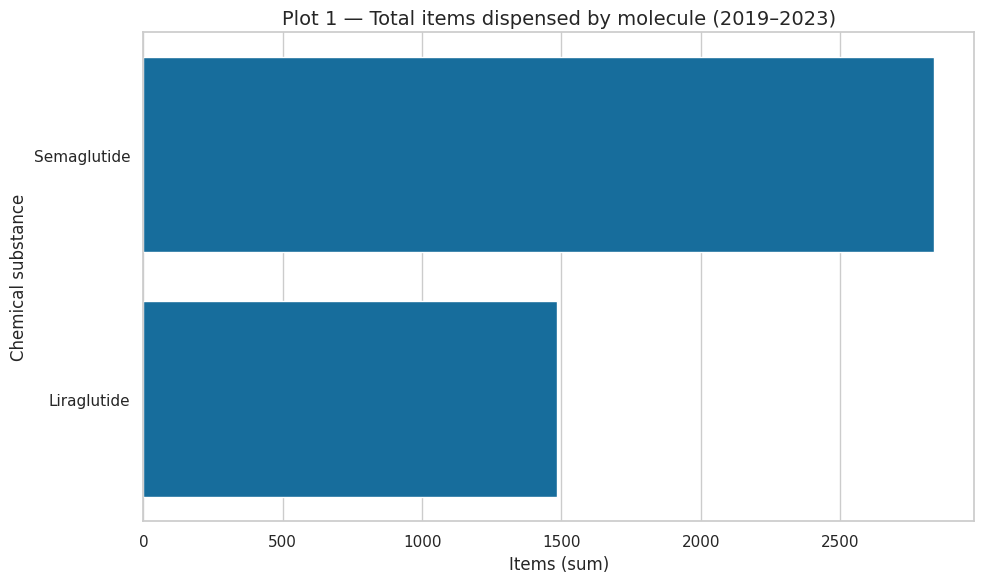

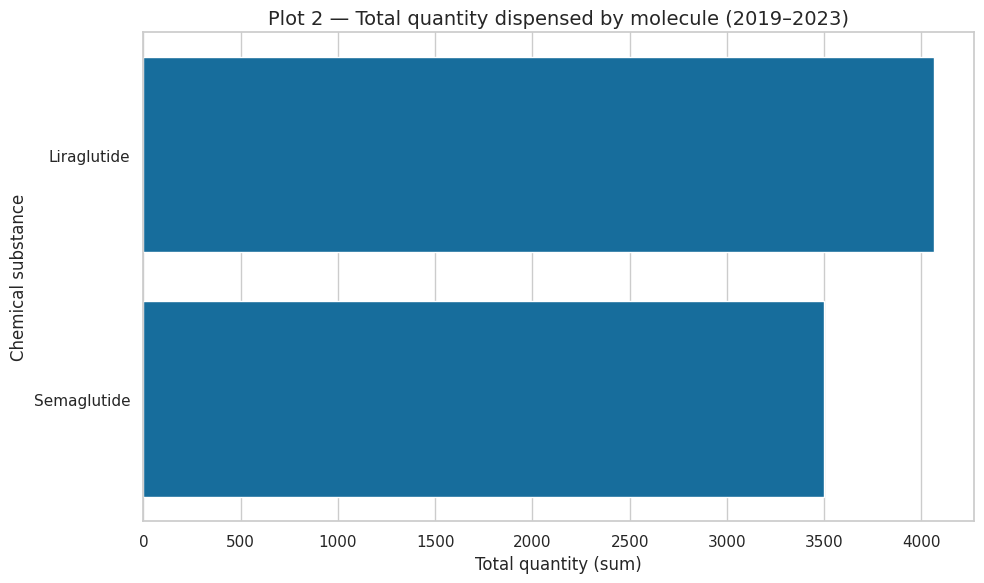

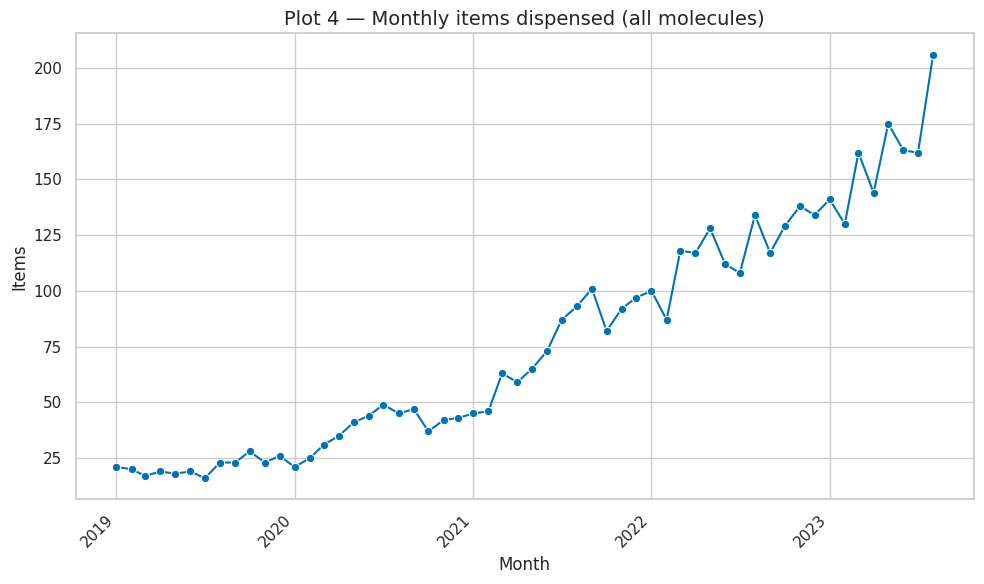

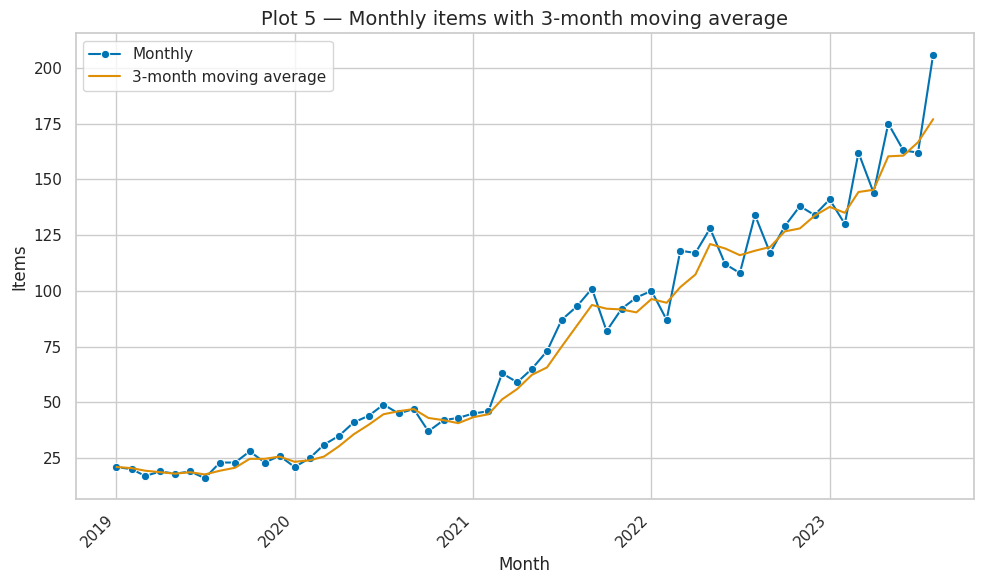

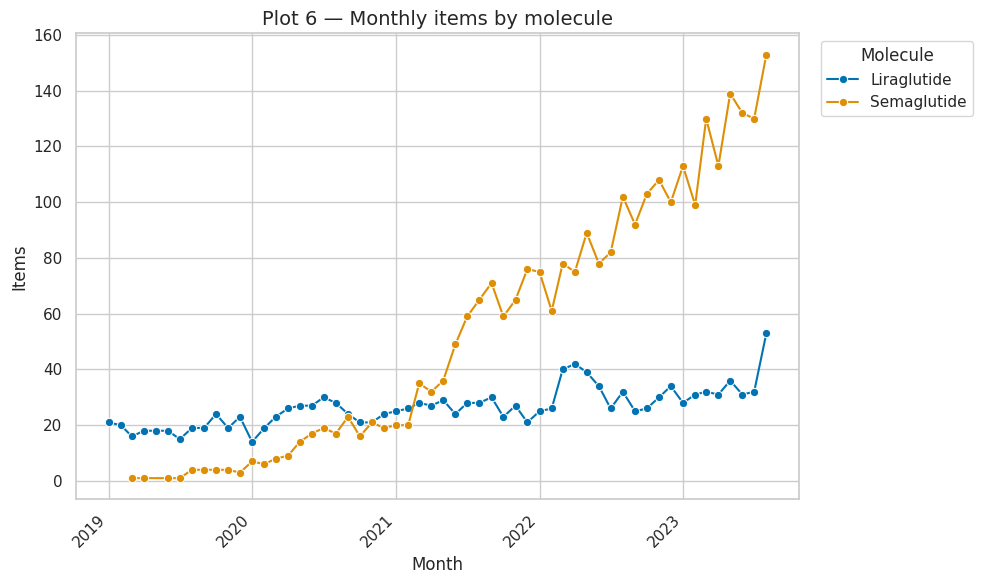

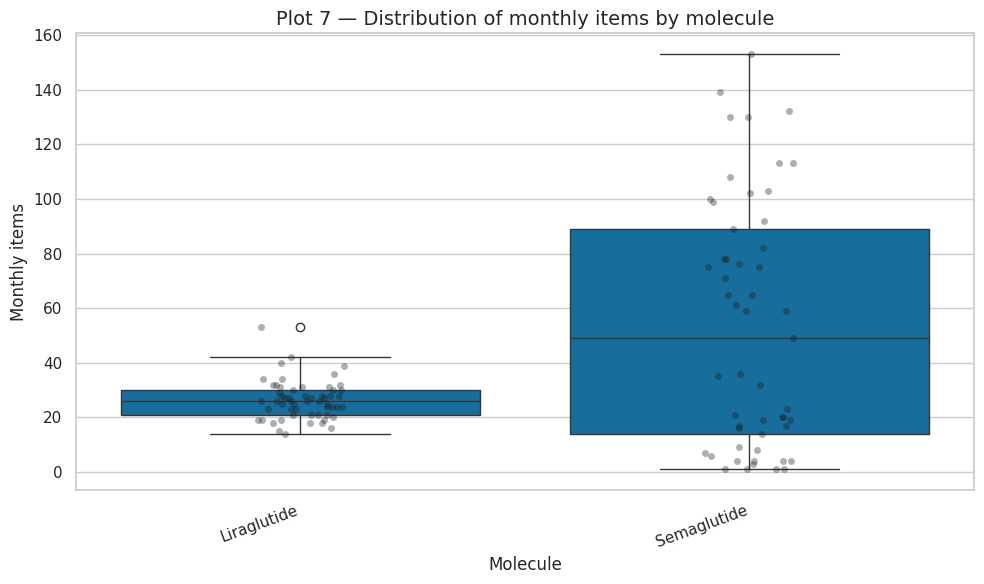

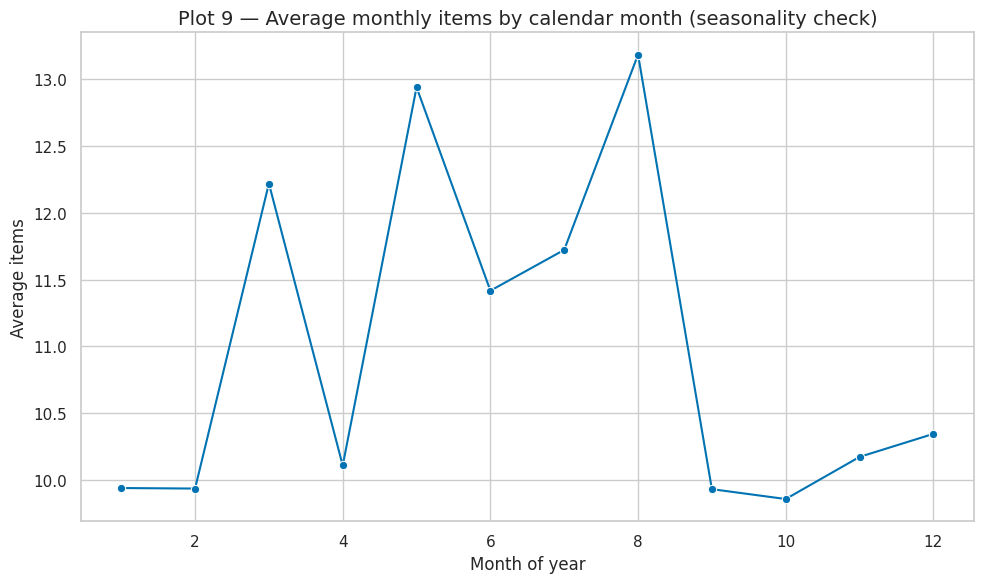

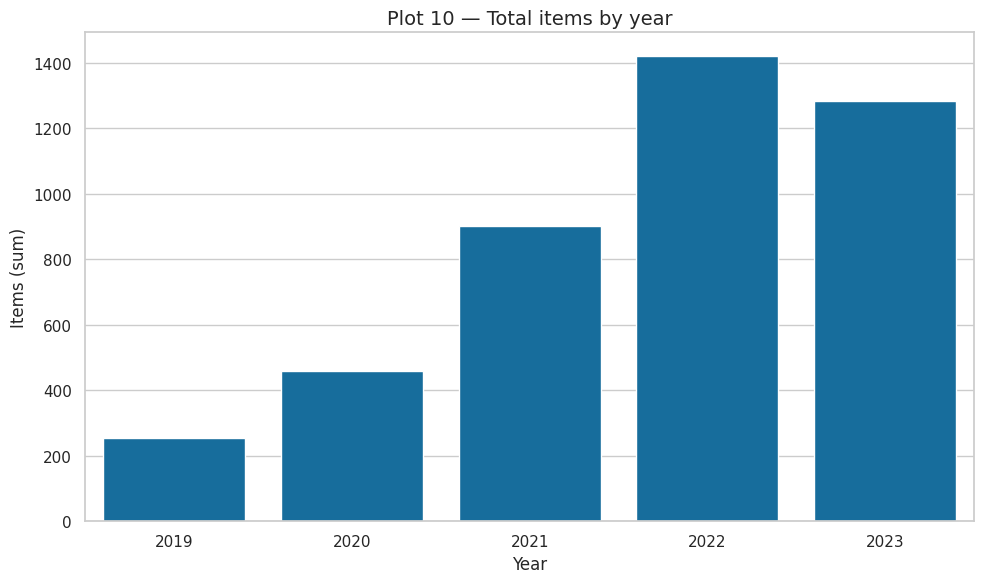

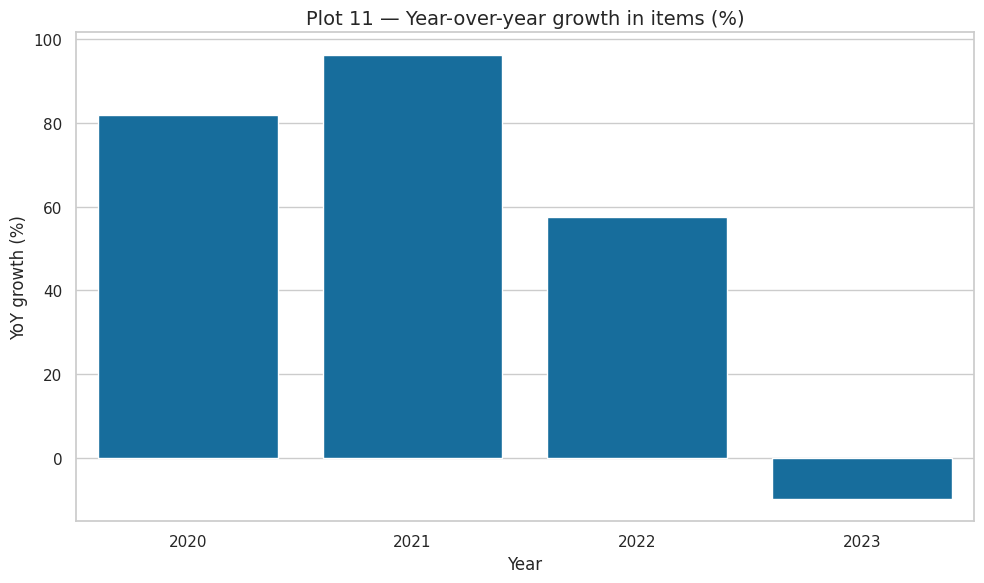

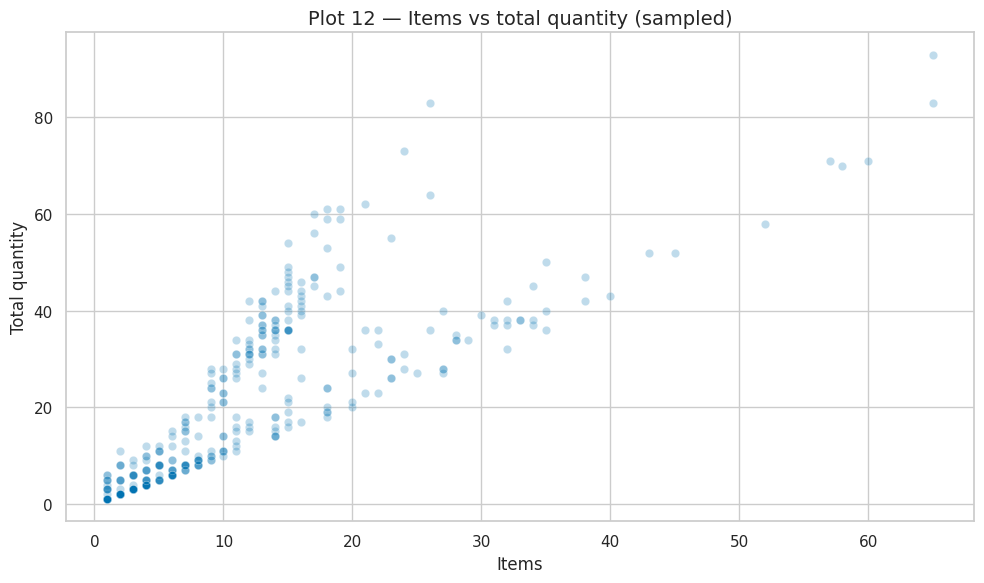

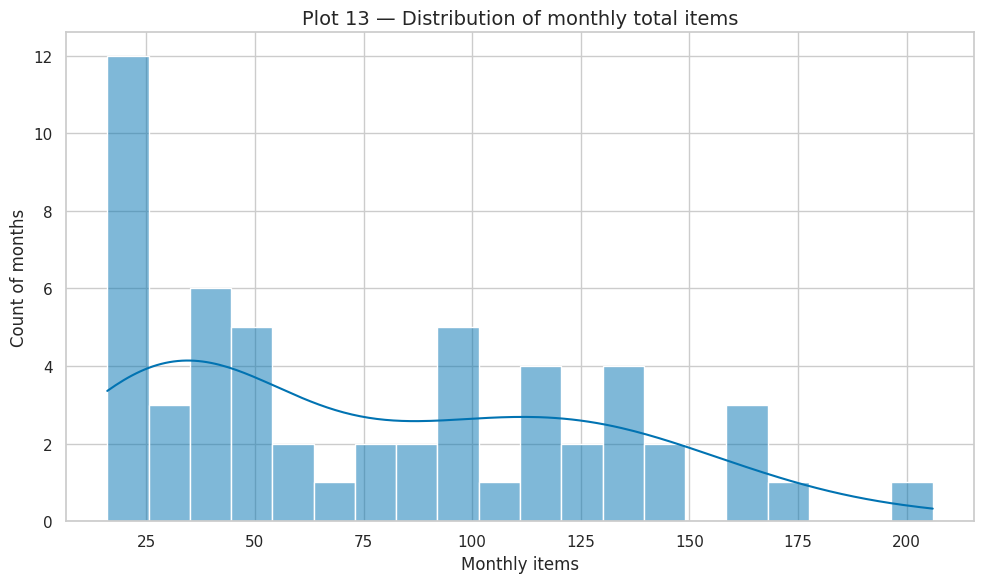

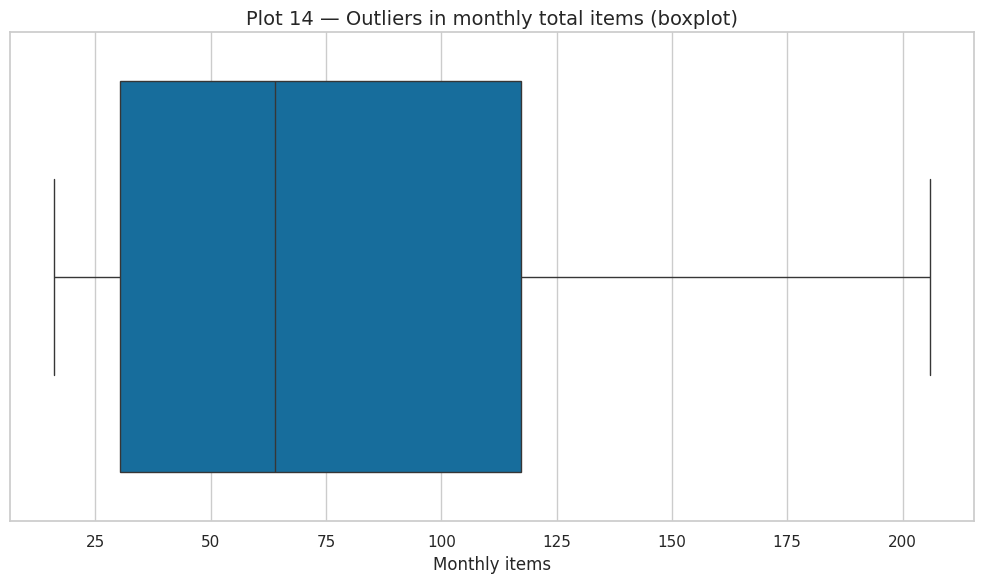

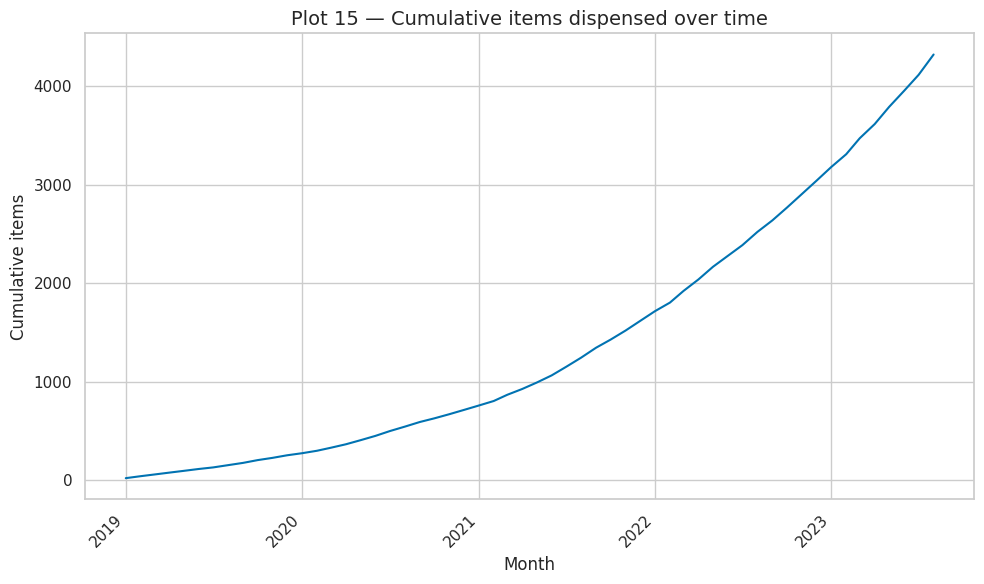

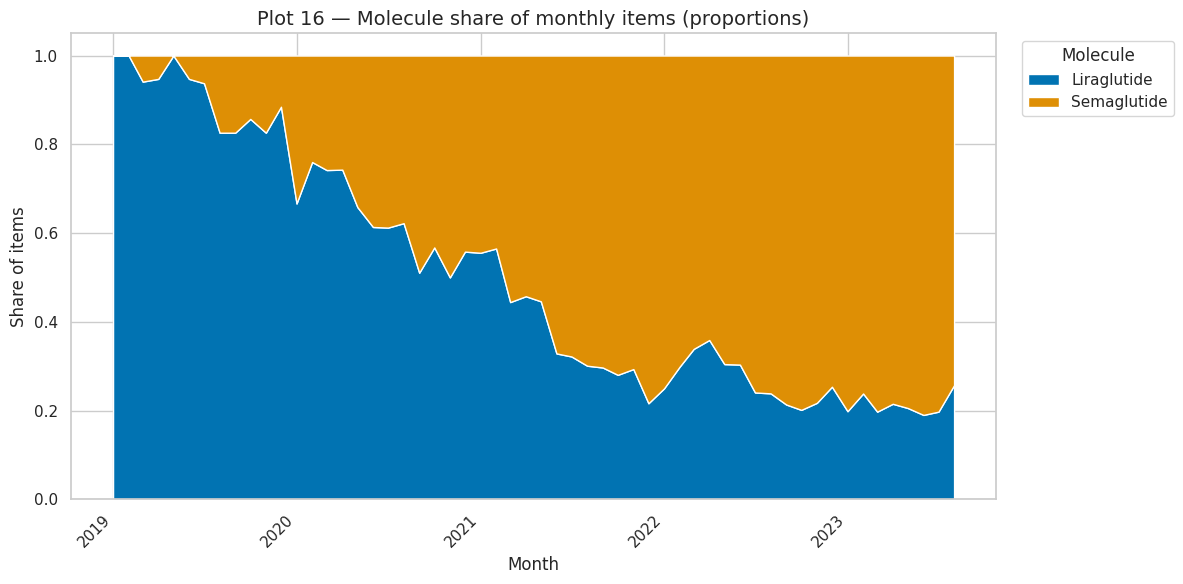

In [67]:
# 8. Medication EDA — Plot set (1–16)

# Plot 1: total items by molecule
if "chemical_substance" in df_med.columns:
    items_by_mol = df_med.groupby("chemical_substance", as_index=False)["items"].sum().sort_values("items", ascending=False)
    plt.figure()
    sns.barplot(data=items_by_mol, x="items", y="chemical_substance")
    plt.title("Plot 1 — Total items dispensed by molecule (2019–2023)")
    plt.xlabel("Items (sum)")
    plt.ylabel("Chemical substance")
    plt.show()

# Plot 2: total quantity by molecule
if "chemical_substance" in df_med.columns and "total_quantity" in df_med.columns:
    qty_by_mol = df_med.groupby("chemical_substance", as_index=False)["total_quantity"].sum().sort_values("total_quantity", ascending=False)
    plt.figure()
    sns.barplot(data=qty_by_mol, x="total_quantity", y="chemical_substance")
    plt.title("Plot 2 — Total quantity dispensed by molecule (2019–2023)")
    plt.xlabel("Total quantity (sum)")
    plt.ylabel("Chemical substance")
    plt.show()

# Plot 3: total items by commercial name (top N)
if "commercial_name" in df_med.columns:
    df_med["commercial_name_top"] = top_n_categories(df_med["commercial_name"], n=12)
    items_by_brand = df_med.groupby("commercial_name_top", as_index=False)["items"].sum().sort_values("items", ascending=False)
    plt.figure()
    sns.barplot(data=items_by_brand, x="items", y="commercial_name_top")
    plt.title("Plot 3 — Total items by commercial name (top 12)")
    plt.xlabel("Items (sum)")
    plt.ylabel("Commercial name")
    plt.show()

# Monthly totals
monthly_all = df_med.groupby("date", as_index=False)["items"].sum().sort_values("date")

# Plot 4: monthly items (overall)
plt.figure()
sns.lineplot(data=monthly_all, x="date", y="items", marker="o")
plt.title("Plot 4 — Monthly items dispensed (all molecules)")
plt.xlabel("Month")
plt.ylabel("Items")
nice_xticks()
plt.show()

# Plot 5: monthly items (rolling mean)
plt.figure()
monthly_all["items_3m_ma"] = monthly_all["items"].rolling(3, min_periods=1).mean()
sns.lineplot(data=monthly_all, x="date", y="items", marker="o", label="Monthly")
sns.lineplot(data=monthly_all, x="date", y="items_3m_ma", label="3-month moving average")
plt.title("Plot 5 — Monthly items with 3-month moving average")
plt.xlabel("Month")
plt.ylabel("Items")
nice_xticks()
plt.legend()
plt.show()

# By molecule time series
if "chemical_substance" in df_med.columns:
    monthly_mol = df_med.groupby(["date", "chemical_substance"], as_index=False)["items"].sum().sort_values("date")

    # Plot 6: monthly items by molecule
    plt.figure()
    sns.lineplot(data=monthly_mol, x="date", y="items", hue="chemical_substance", marker="o")
    plt.title("Plot 6 — Monthly items by molecule")
    plt.xlabel("Month")
    plt.ylabel("Items")
    nice_xticks()
    plt.legend(title="Molecule", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()

    # Plot 7: boxplot distribution of monthly items by molecule
    plt.figure()
    sns.boxplot(data=monthly_mol, x="chemical_substance", y="items")
    sns.stripplot(data=monthly_mol, x="chemical_substance", y="items", color="k", alpha=0.35, jitter=True)
    plt.title("Plot 7 — Distribution of monthly items by molecule")
    plt.xlabel("Molecule")
    plt.ylabel("Monthly items")
    nice_xticks(20)
    plt.show()

# By commercial name time series (top N)
if "commercial_name" in df_med.columns:
    monthly_brand = df_med.groupby(["date", "commercial_name_top"], as_index=False)["items"].sum().sort_values("date")

    # Plot 8: monthly items by commercial name (top 12)
    plt.figure()
    sns.lineplot(data=monthly_brand, x="date", y="items", hue="commercial_name_top", marker="o")
    plt.title("Plot 8 — Monthly items by commercial name (top 12)")
    plt.xlabel("Month")
    plt.ylabel("Items")
    nice_xticks()
    plt.legend(title="Brand", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()

# Plot 9: seasonality (month-of-year) overall
season = df_med.groupby("month", as_index=False)["items"].mean()
plt.figure()
sns.lineplot(data=season, x="month", y="items", marker="o")
plt.title("Plot 9 — Average monthly items by calendar month (seasonality check)")
plt.xlabel("Month of year")
plt.ylabel("Average items")
plt.show()

# Plot 10: year totals (overall)
year_totals = df_med.groupby("year", as_index=False)["items"].sum().sort_values("year")
plt.figure()
sns.barplot(data=year_totals, x="year", y="items")
plt.title("Plot 10 — Total items by year")
plt.xlabel("Year")
plt.ylabel("Items (sum)")
plt.show()

# Plot 11: year-over-year growth
year_totals["yoy_growth_pct"] = year_totals["items"].pct_change() * 100
plt.figure()
sns.barplot(data=year_totals.dropna(), x="year", y="yoy_growth_pct")
plt.title("Plot 11 — Year-over-year growth in items (%)")
plt.xlabel("Year")
plt.ylabel("YoY growth (%)")
plt.show()

# Plot 12: items vs total_quantity (if both exist)
if {"items", "total_quantity"}.issubset(df_med.columns):
    plt.figure()
    sns.scatterplot(data=df_med.sample(min(5000, len(df_med)), random_state=42), x="items", y="total_quantity", alpha=0.25)
    plt.title("Plot 12 — Items vs total quantity (sampled)")
    plt.xlabel("Items")
    plt.ylabel("Total quantity")
    plt.show()

# Plot 13: distribution of monthly totals (overall)
plt.figure()
sns.histplot(monthly_all["items"], kde=True, bins=20)
plt.title("Plot 13 — Distribution of monthly total items")
plt.xlabel("Monthly items")
plt.ylabel("Count of months")
plt.show()

# Plot 14: outliers in monthly totals (boxplot)
plt.figure()
sns.boxplot(x=monthly_all["items"])
plt.title("Plot 14 — Outliers in monthly total items (boxplot)")
plt.xlabel("Monthly items")
plt.show()

# Plot 15: cumulative items over time
monthly_all["cum_items"] = monthly_all["items"].cumsum()
plt.figure()
sns.lineplot(data=monthly_all, x="date", y="cum_items")
plt.title("Plot 15 — Cumulative items dispensed over time")
plt.xlabel("Month")
plt.ylabel("Cumulative items")
nice_xticks()
plt.show()

# Plot 16: share by molecule over time (stacked area-ish via proportions)
if "chemical_substance" in df_med.columns:
    piv = monthly_mol.pivot_table(index="date", columns="chemical_substance", values="items", aggfunc="sum").fillna(0)
    share = piv.div(piv.sum(axis=1), axis=0)

    plt.figure(figsize=(12, 6))
    plt.stackplot(share.index, share.T.values, labels=share.columns)
    plt.title("Plot 16 — Molecule share of monthly items (proportions)")
    plt.xlabel("Month")
    plt.ylabel("Share of items")
    nice_xticks()
    plt.legend(title="Molecule", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()

## Trend inference note (sample size)

Trend models are fit on monthly time points. With 2019–2023 monthly data, this typically yields ~60 observations per molecule, which is adequate for OLS slope estimation and for running a Breusch–Pagan test (n is comfortably larger than the number of parameters).

In [68]:
# 9. Medication trend modelling with OLS + hypothesis testing (molecule-level)

if "chemical_substance" in df_med.columns:
    # Rebuild monthly_mol to ensure it's available
    monthly_mol = df_med.groupby(["date", "chemical_substance"], as_index=False)["items"].sum().sort_values("date")

    # Create deterministic time_index
    month_order = pd.Series(sorted(df_med["date"].unique()))
    month_to_index = {m: i for i, m in enumerate(month_order)}
    monthly_mol["time_index"] = monthly_mol["date"].map(month_to_index)

    trend_rows = []
    for mol, sub in monthly_mol.groupby("chemical_substance"):
        m = ols_fit(sub["items"], sub[["time_index"]])
        ci = m.conf_int().loc["time_index"]
        trend_rows.append({
            "chemical_substance": mol,
            "slope_items_per_month": m.params["time_index"],
            "p_value_slope": m.pvalues["time_index"],
            "ci_low": ci[0],
            "ci_high": ci[1],
            "r2": m.rsquared,
            "n_months": len(sub)
        })

    trend_df = pd.DataFrame(trend_rows).sort_values("slope_items_per_month", ascending=False)
    display(trend_df)

chemical_substance  slope_items_per_month  p_value_slope  ci_low  ci_high  \
1        Semaglutide                   2.82           0.00    2.62     3.03   
0        Liraglutide                   0.32           0.00    0.24     0.40   

    r2  n_months  
1 0.94        53  
0 0.55        56

In [69]:
# 9. Medication trend modelling with OLS + hypothesis testing (molecule-level)

if "chemical_substance" in df_med.columns:
    # Rebuild monthly_mol to ensure it's available
    monthly_mol = df_med.groupby(["date", "chemical_substance"], as_index=False)["items"].sum().sort_values("date")

    # Create deterministic time_index
    month_order = pd.Series(sorted(df_med["date"].unique()))
    month_to_index = {m: i for i, m in enumerate(month_order)}
    monthly_mol["time_index"] = monthly_mol["date"].map(month_to_index)

    trend_rows = []
    for mol, sub in monthly_mol.groupby("chemical_substance"):
        m = ols_fit(sub["items"], sub[["time_index"]])
        ci = m.conf_int().loc["time_index"]
        trend_rows.append({
            "chemical_substance": mol,
            "slope_items_per_month": m.params["time_index"],
            "p_value_slope": m.pvalues["time_index"],
            "ci_low": ci[0],
            "ci_high": ci[1],
            "r2": m.rsquared,
            "n_months": len(sub)
        })

    trend_df = pd.DataFrame(trend_rows).sort_values("slope_items_per_month", ascending=False)
    display(trend_df)

chemical_substance  slope_items_per_month  p_value_slope  ci_low  ci_high  \
1        Semaglutide                   2.82           0.00    2.62     3.03   
0        Liraglutide                   0.32           0.00    0.24     0.40   

    r2  n_months  
1 0.94        53  
0 0.55        56

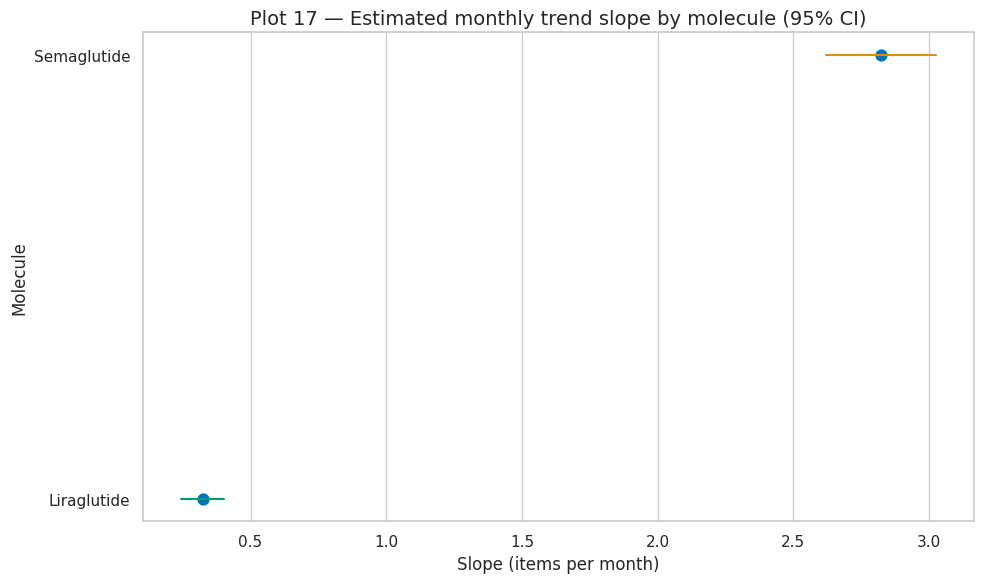

In [70]:
# Plot 17: slope per molecule (with CI)
if "chemical_substance" in df_med.columns and len(trend_df) > 0:
    plt.figure()
    order = trend_df["chemical_substance"].tolist()
    sns.pointplot(
        data=trend_df,
        y="chemical_substance",
        x="slope_items_per_month",
        order=order,
        join=False
    )
    for i, row in enumerate(trend_df.itertuples(index=False)):
        plt.plot([row.ci_low, row.ci_high], [i, i])
    plt.title("Plot 17 — Estimated monthly trend slope by molecule (95% CI)")
    plt.xlabel("Slope (items per month)")
    plt.ylabel("Molecule")
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                  items   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     776.0
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           1.61e-32
Time:                        14:57:07   Log-Likelihood:                -202.86
No. Observations:                  53   AIC:                             409.7
Df Residuals:                      51   BIC:                             413.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.2292      3.323     -8.495      0.0

LM stat      0.10
LM p-value   0.76
F stat       0.09
F p-value    0.76
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                  items   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     502.2
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           4.64e-28
Time:                        14:57:07   Log-Likelihood:                -202.86
No. Observations:                  53   AIC:                             409.7
Df Residuals:                      51   BIC:                             413.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.2292      4.053     -6.965      0.0

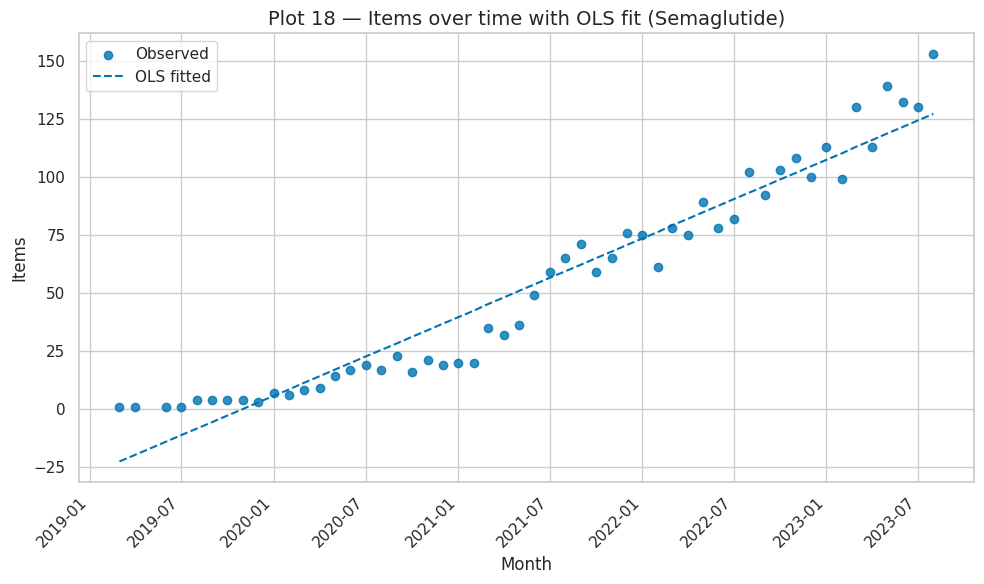

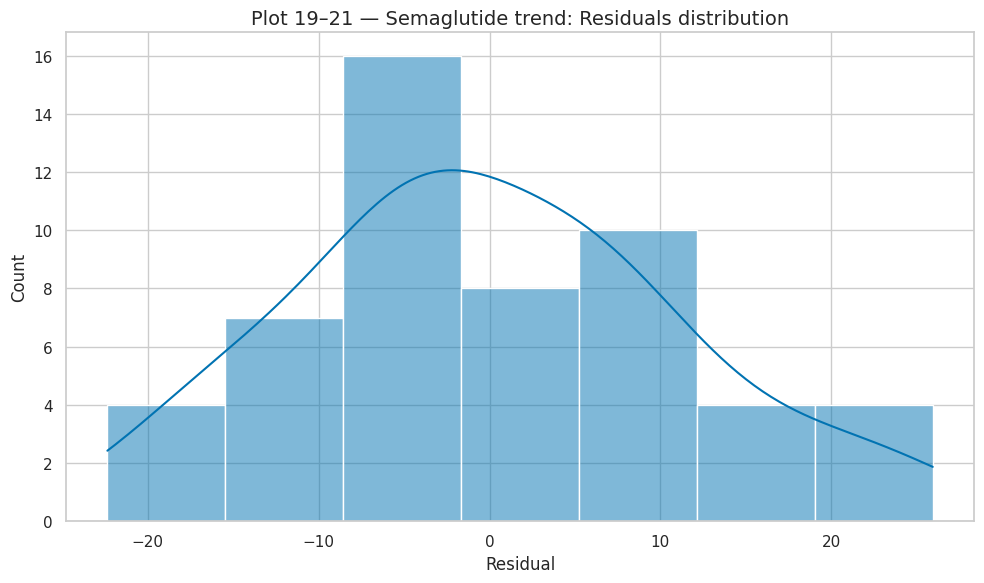

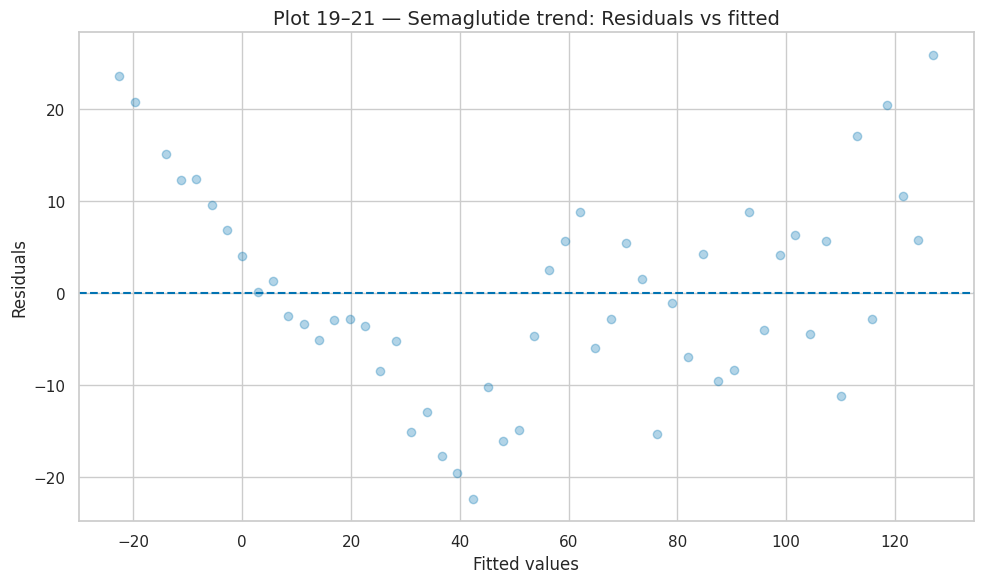

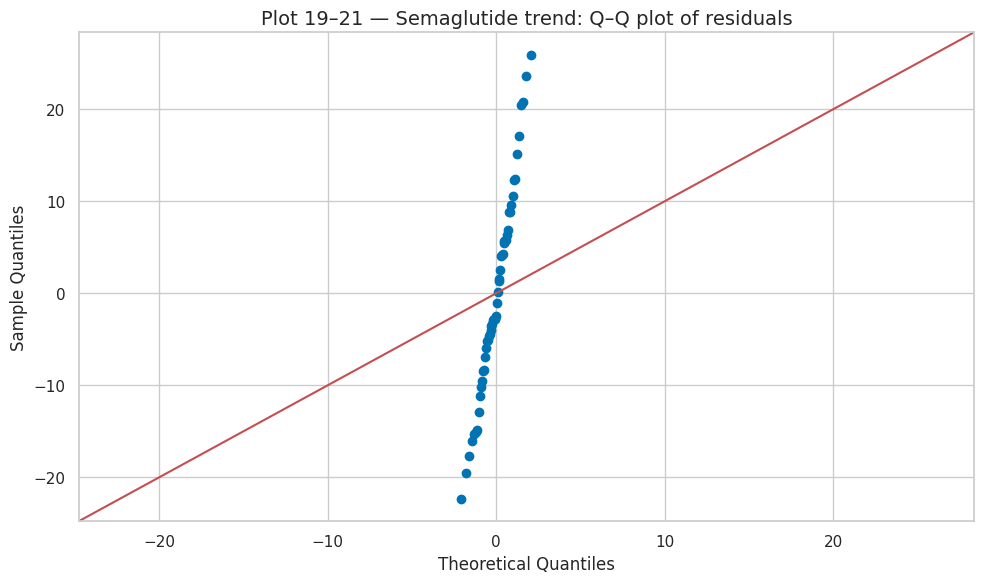

In [71]:
# Plot 18–20: pick top-trending molecule and run diagnostics + BP + robust SE

if "chemical_substance" in df_med.columns and len(trend_df) > 0:
    mol_top = trend_df.iloc[0]["chemical_substance"]
    sub = monthly_mol[monthly_mol["chemical_substance"] == mol_top].copy()

    m_trend = ols_fit(sub["items"], sub[["time_index"]])
    print(m_trend.summary())

    # Breusch–Pagan
    bp = breusch_pagan_test(m_trend)
    display(bp)

    # Robust SE (HC3)
    m_trend_robust = m_trend.get_robustcov_results(cov_type="HC3")
    print(m_trend_robust.summary())

    # Plot 18: observed vs fitted
    sub["fitted"] = m_trend.fittedvalues
    plt.figure()
    plt.scatter(sub["date"], sub["items"], alpha=0.8, label="Observed")
    plt.plot(sub["date"], sub["fitted"], linestyle="--", label="OLS fitted")
    plt.title(f"Plot 18 — Items over time with OLS fit ({mol_top})")
    plt.xlabel("Month")
    plt.ylabel("Items")
    nice_xticks()
    plt.legend()
    plt.show()

    # Plot 19–21: diagnostics (hist, resid-vs-fitted, QQ)
    regression_diagnostics(m_trend, title_prefix=f"Plot 19–21 — {mol_top} trend:")

### Robust inference (why it’s used)

If the Breusch–Pagan p-value suggests heteroscedasticity, classic OLS standard errors can be optimistic.  
In that case, **HC3 robust standard errors** are used to provide more reliable p-values and confidence intervals, while keeping coefficients unchanged.

# Part B — Diabetes dataset EDA (patient-level risk)

This section follows an EDA workflow:
1) univariate distributions,
2) bivariate relationships,
3) correlation structure,
4) hypothesis testing examples,
5) supervised learning models and diagnostics.

In [72]:
# 10. Diabetes EDA — numeric summary

numeric_cols = [c for c in [
    "age", "bmi", "waist_to_hip_ratio",
    "systolic_bp", "diastolic_bp",
    "cholesterol_total", "hdl_cholesterol", "ldl_cholesterol",
    "triglycerides",
    "glucose_fasting", "glucose_postprandial",
    "insulin_level", "hba1c", "diabetes_risk_score"
] if c in df_diab.columns]

display(df_diab[numeric_cols].describe())

bmi  waist_to_hip_ratio  systolic_bp  diastolic_bp  \
count 97,297.00           97,297.00    97,297.00     97,297.00   
mean      25.62                0.86       115.80         75.23   
std        3.59                0.05        14.29          8.21   
min       15.00                0.67        90.00         50.00   
25%       23.20                0.82       106.00         70.00   
50%       25.60                0.86       116.00         75.00   
75%       28.00                0.89       125.00         81.00   
max       39.20                1.06       179.00        110.00   

       cholesterol_total  hdl_cholesterol  ldl_cholesterol  triglycerides  \
count          97,297.00        97,297.00        97,297.00      97,297.00   
mean              185.98            54.04           103.00         121.47   
std                32.01            10.28            33.39          43.39   
min               100.00            20.00            50.00          30.00   
25%               164.00            47.00            78.00          91.00   
50%               186.00            54.00           102.00         121.00   
75%               208.00            61.00           126.00         151.00   
max               318.00            98.00           263.00         344.00   

       glucose_fasting  glucose_postprandial  insulin_level     hba1c  \
count        97,297.00             97,297.00      97,297.00 97,297.00   
mean            111.12                160.01           9.06      6.52   
std              13.59                 30.94           4.96      0.81   
min              60.00                 70.00           2.00      4.00   
25%             102.00                139.00           5.09      5.97   
50%             111.00                160.00           8.79      6.52   
75%             120.00                181.00          12.45      7.07   
max             172.00                287.00          32.22      9.80   

       diabetes_risk_score  
count            97,297.00  
mean                 30.22  
std                   9.07  
min                   2.70  
25%                  23.80  
50%                  29.00  
75%                  35.60  
max                  67.20

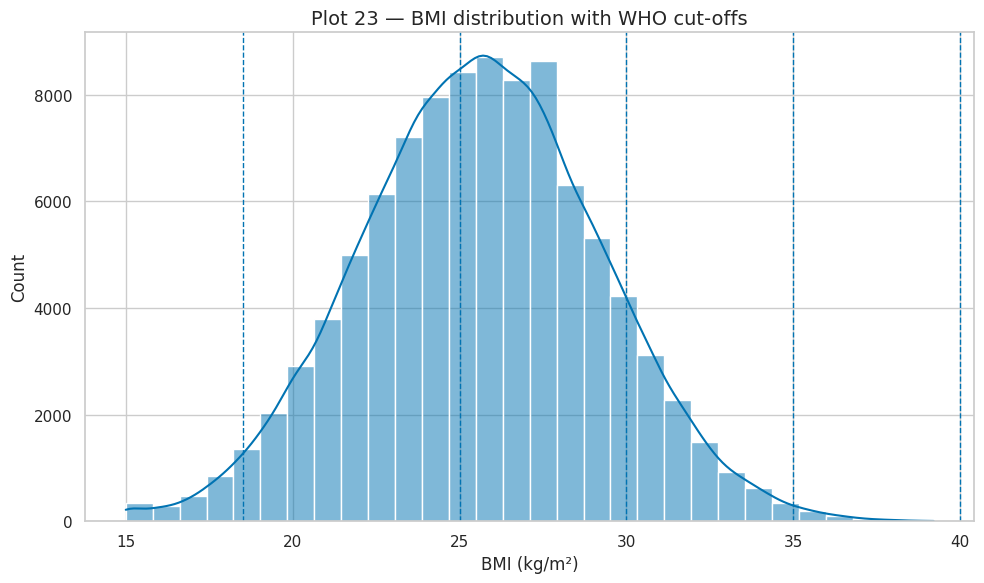

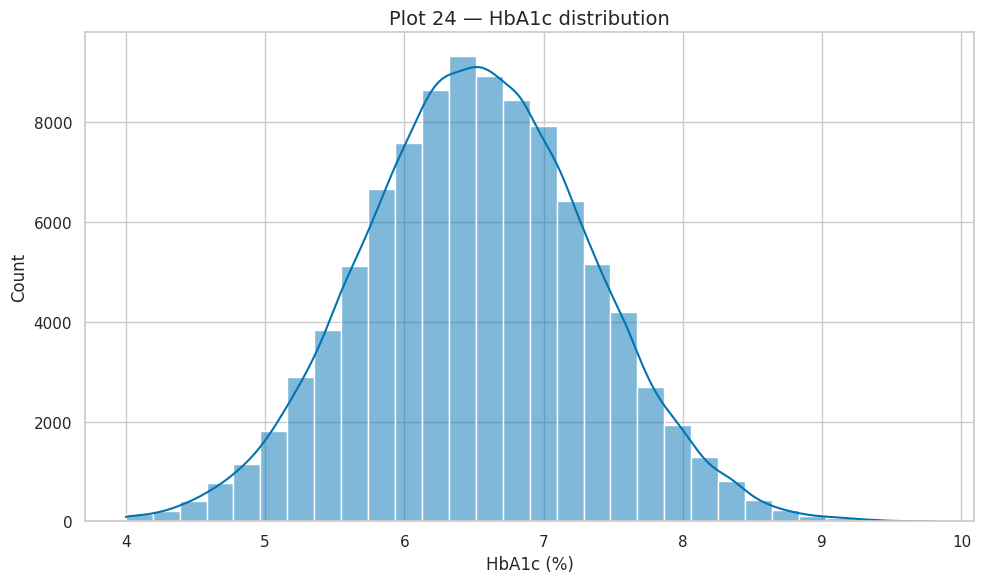

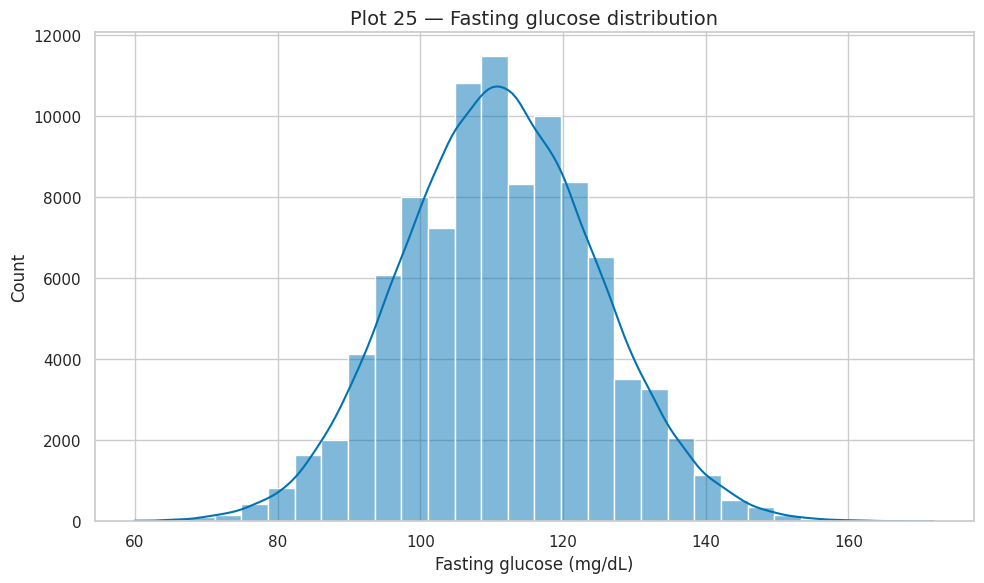

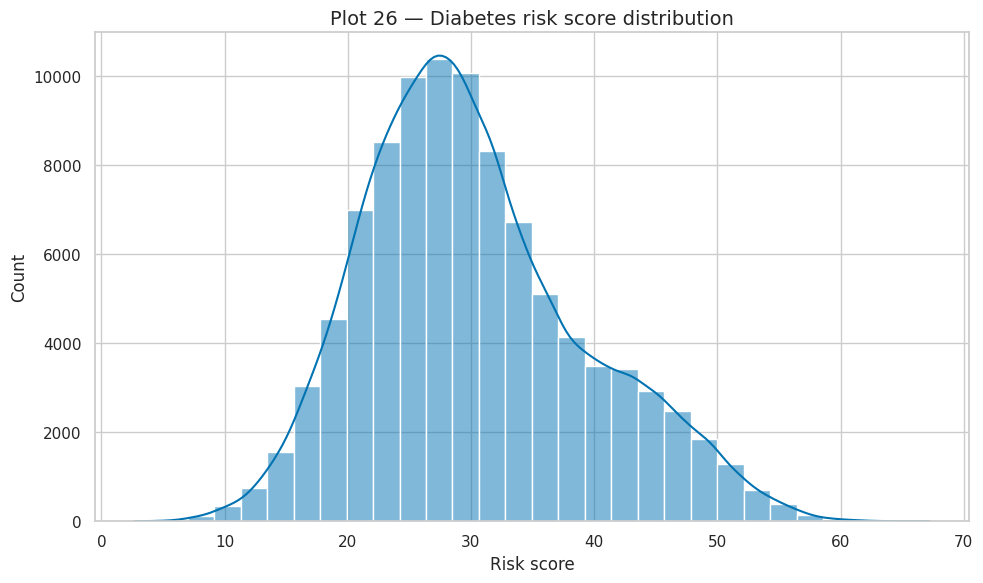

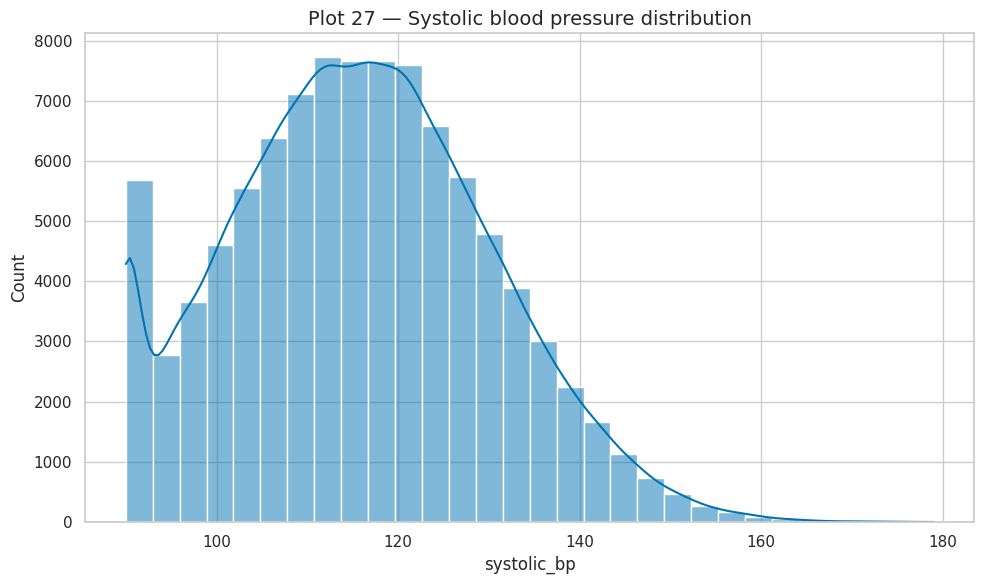

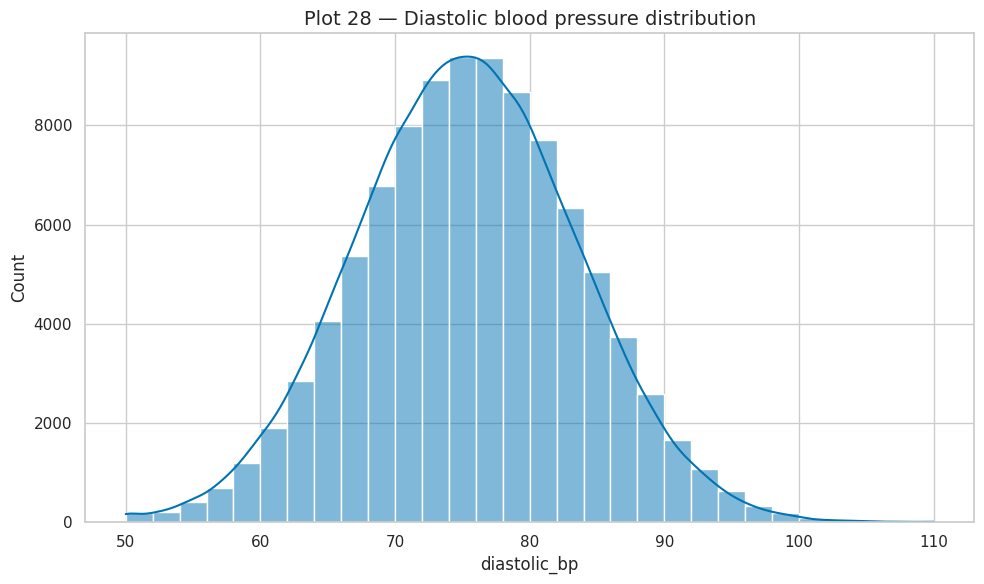

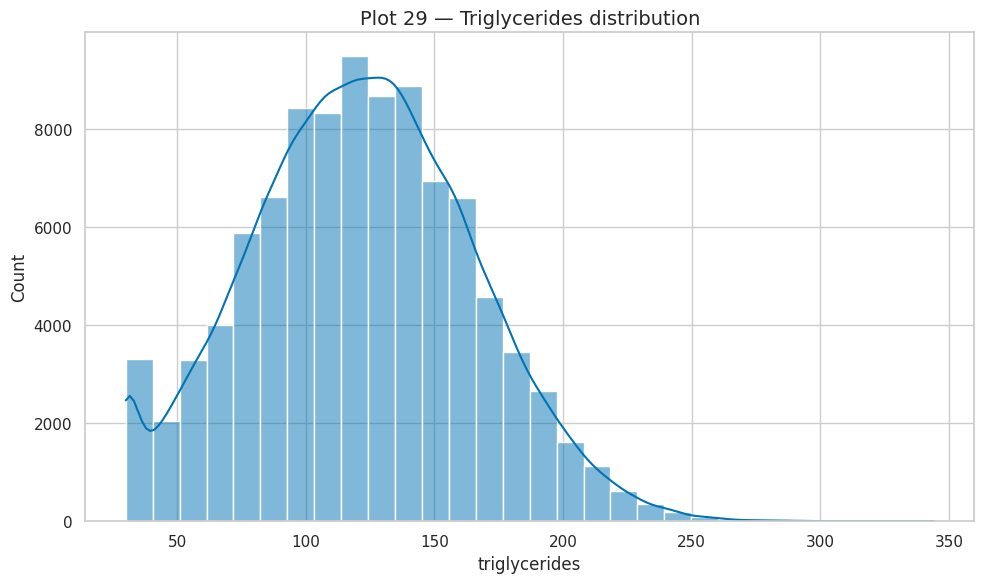

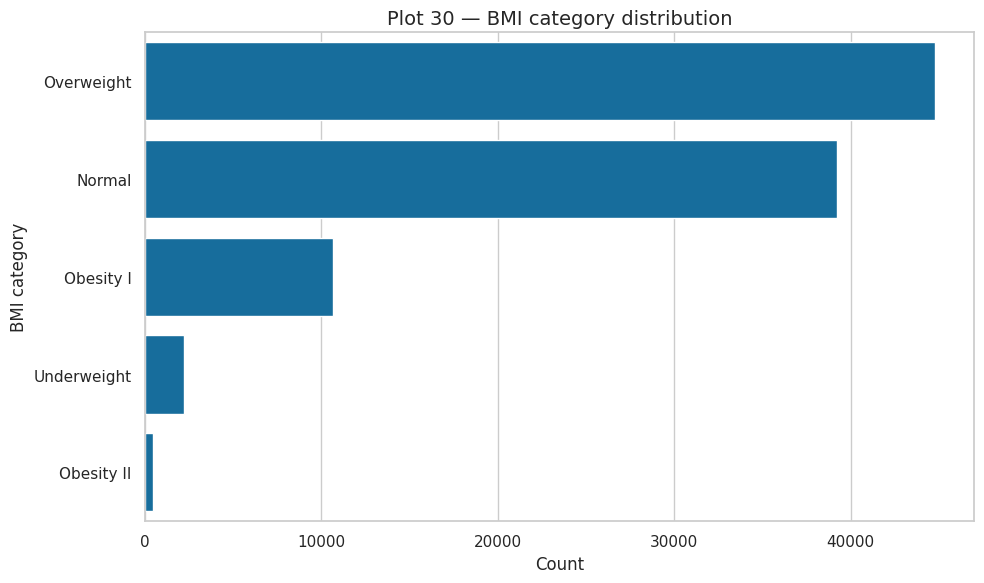

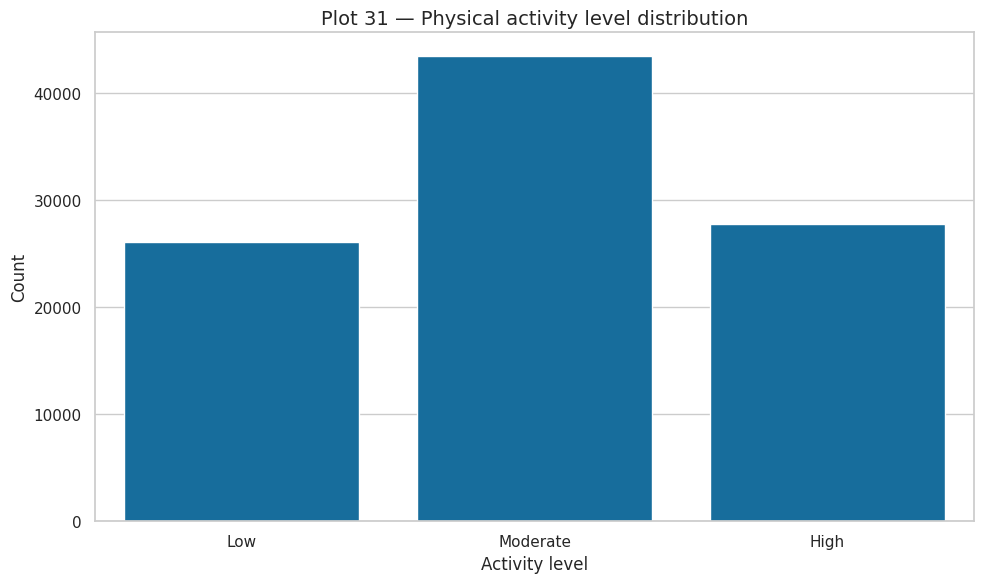

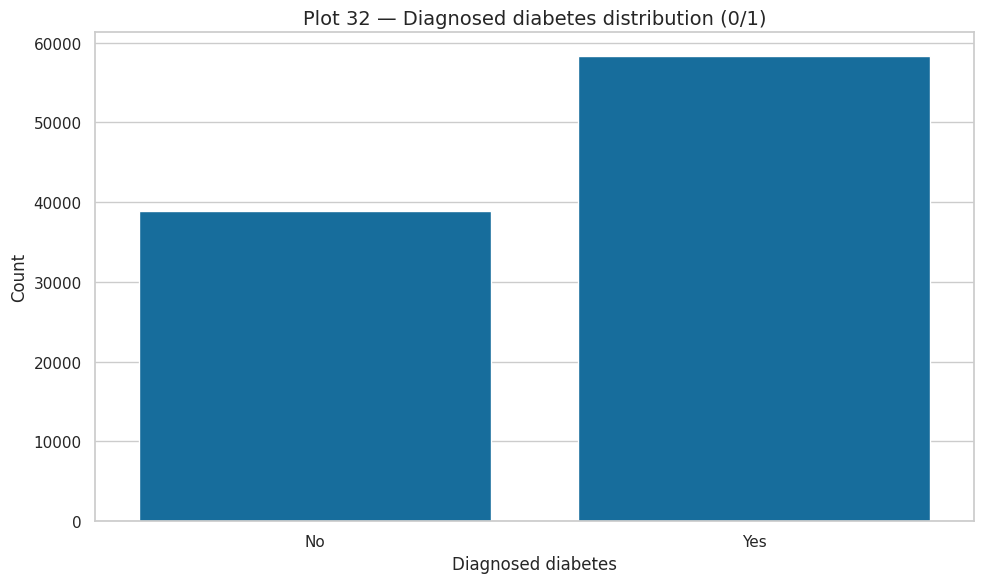

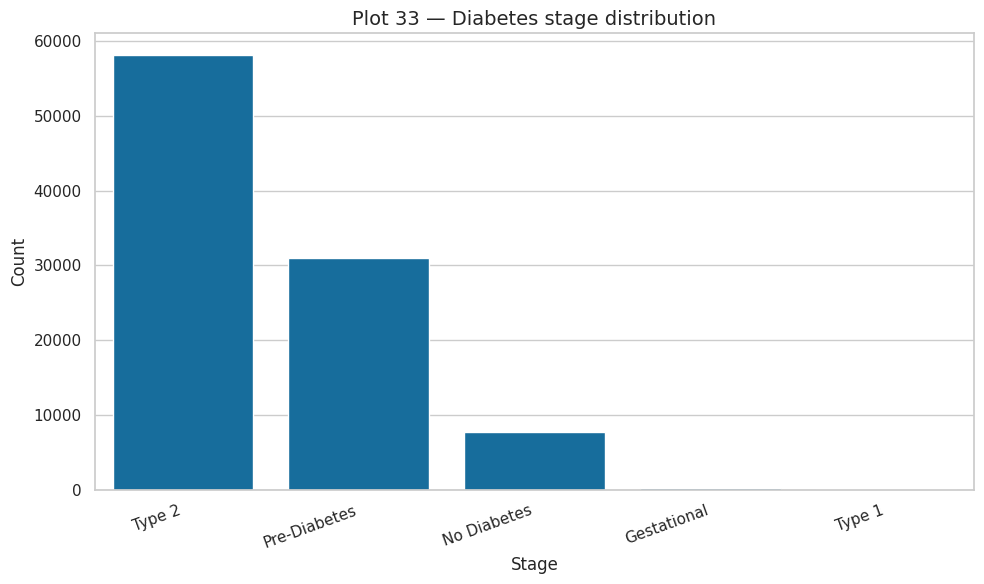

In [73]:
# 11. Univariate plots (Plots 22–33)

# Plot 22: age histogram
if "age" in df_diab.columns:
    plt.figure()
    sns.histplot(df_diab["age"], kde=True, bins=30)
    plt.title("Plot 22 — Age distribution")
    plt.xlabel("Age (years)")
    plt.ylabel("Count")
    plt.show()

# Plot 23: BMI histogram with WHO cut-offs
if "bmi" in df_diab.columns:
    plt.figure()
    sns.histplot(df_diab["bmi"], kde=True, bins=30)
    for v in [18.5, 25, 30, 35, 40]:
        plt.axvline(v, linestyle="--", linewidth=1)
    plt.title("Plot 23 — BMI distribution with WHO cut-offs")
    plt.xlabel("BMI (kg/m²)")
    plt.ylabel("Count")
    plt.show()

# Plot 24: HbA1c distribution
if "hba1c" in df_diab.columns:
    plt.figure()
    sns.histplot(df_diab["hba1c"], kde=True, bins=30)
    plt.title("Plot 24 — HbA1c distribution")
    plt.xlabel("HbA1c (%)")
    plt.ylabel("Count")
    plt.show()

# Plot 25: fasting glucose distribution
if "glucose_fasting" in df_diab.columns:
    plt.figure()
    sns.histplot(df_diab["glucose_fasting"], kde=True, bins=30)
    plt.title("Plot 25 — Fasting glucose distribution")
    plt.xlabel("Fasting glucose (mg/dL)")
    plt.ylabel("Count")
    plt.show()

# Plot 26: risk score distribution
if "diabetes_risk_score" in df_diab.columns:
    plt.figure()
    sns.histplot(df_diab["diabetes_risk_score"], kde=True, bins=30)
    plt.title("Plot 26 — Diabetes risk score distribution")
    plt.xlabel("Risk score")
    plt.ylabel("Count")
    plt.show()

# Plot 27–29: BP and lipids (if present)
for col, title in [
    ("systolic_bp", "Plot 27 — Systolic blood pressure distribution"),
    ("diastolic_bp", "Plot 28 — Diastolic blood pressure distribution"),
    ("triglycerides", "Plot 29 — Triglycerides distribution"),
]:
    if col in df_diab.columns:
        plt.figure()
        sns.histplot(df_diab[col], kde=True, bins=30)
        plt.title(title)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

# Plot 30: BMI category counts
if "bmi_category" in df_diab.columns:
    plt.figure()
    sns.countplot(data=df_diab, y="bmi_category",
                  order=df_diab["bmi_category"].value_counts().index)
    plt.title("Plot 30 — BMI category distribution")
    plt.xlabel("Count")
    plt.ylabel("BMI category")
    plt.show()

# Plot 31: activity level counts
if "activity_level" in df_diab.columns:
    plt.figure()
    sns.countplot(data=df_diab, x="activity_level", order=["Low", "Moderate", "High"])
    plt.title("Plot 31 — Physical activity level distribution")
    plt.xlabel("Activity level")
    plt.ylabel("Count")
    plt.show()

# Plot 32: diabetes diagnosis counts
if "diagnosed_diabetes" in df_diab.columns:
    plt.figure()
    sns.countplot(data=df_diab, x="diagnosed_diabetes")
    plt.title("Plot 32 — Diagnosed diabetes distribution (0/1)")
    plt.xlabel("Diagnosed diabetes")
    plt.ylabel("Count")
    plt.xticks([0,1], ["No", "Yes"])
    plt.show()

# Plot 33: diabetes stage counts
if "diabetes_stage" in df_diab.columns:
    plt.figure()
    sns.countplot(data=df_diab, x="diabetes_stage",
                  order=df_diab["diabetes_stage"].value_counts().index)
    plt.title("Plot 33 — Diabetes stage distribution")
    plt.xlabel("Stage")
    plt.ylabel("Count")
    nice_xticks(20)
    plt.show()

BMI IQR bounds: [16.00, 35.20] | Outliers: 729


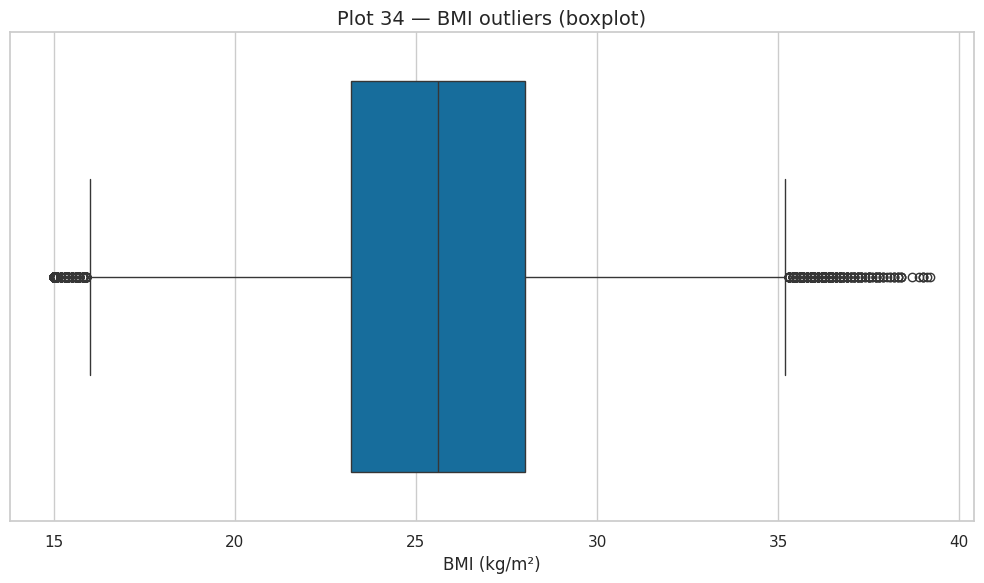

HbA1c IQR bounds: [4.32, 8.72] | Outliers: 599


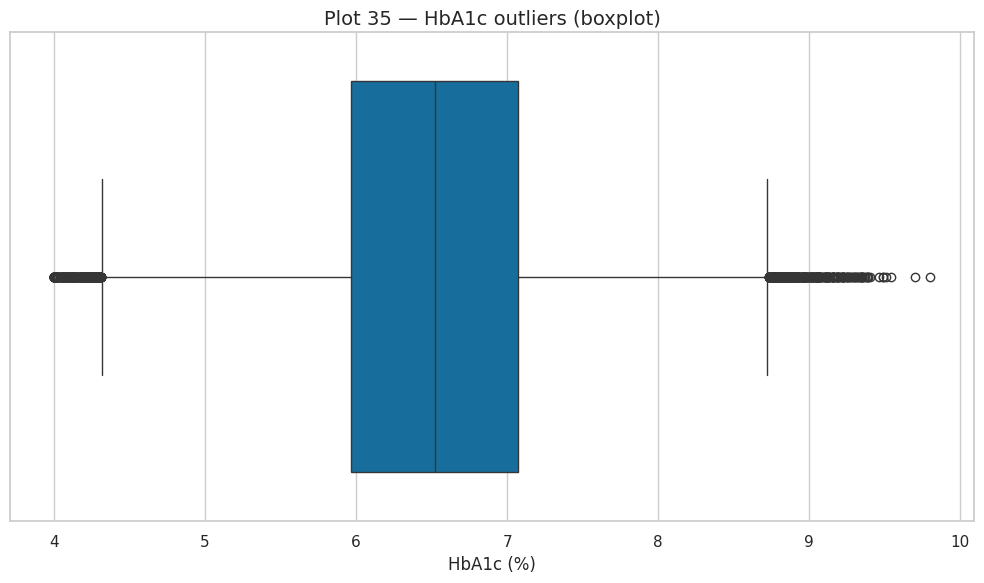

In [74]:
# 12. Outliers (IQR) with quick visuals (Plots 34–35)

if "bmi" in df_diab.columns:
    lo, hi, out = iqr_outliers(df_diab["bmi"])
    print(f"BMI IQR bounds: [{lo:.2f}, {hi:.2f}] | Outliers: {len(out)}")

    plt.figure()
    sns.boxplot(x=df_diab["bmi"])
    plt.title("Plot 34 — BMI outliers (boxplot)")
    plt.xlabel("BMI (kg/m²)")
    plt.show()

if "hba1c" in df_diab.columns:
    lo, hi, out = iqr_outliers(df_diab["hba1c"])
    print(f"HbA1c IQR bounds: [{lo:.2f}, {hi:.2f}] | Outliers: {len(out)}")

    plt.figure()
    sns.boxplot(x=df_diab["hba1c"])
    plt.title("Plot 35 — HbA1c outliers (boxplot)")
    plt.xlabel("HbA1c (%)")
    plt.show()

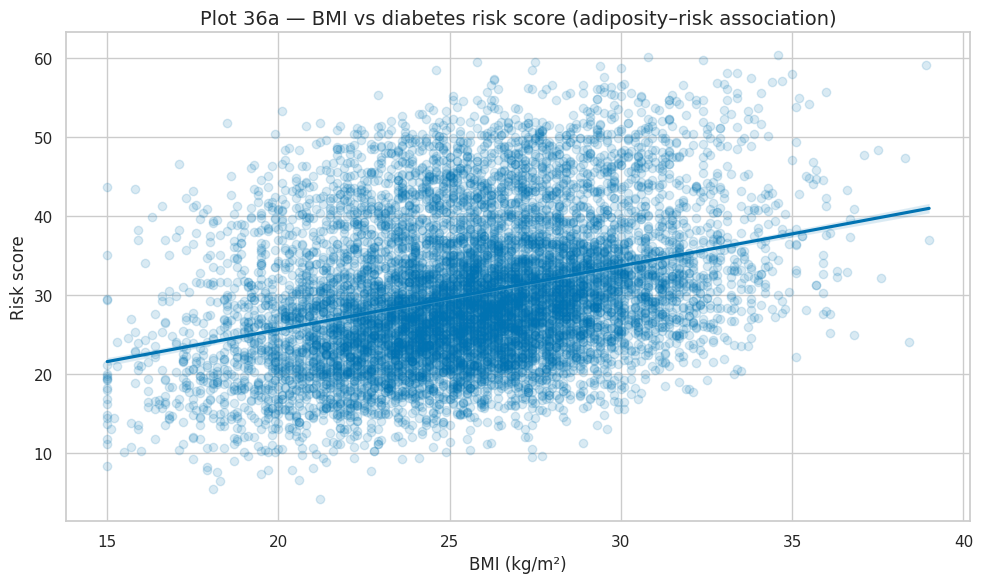

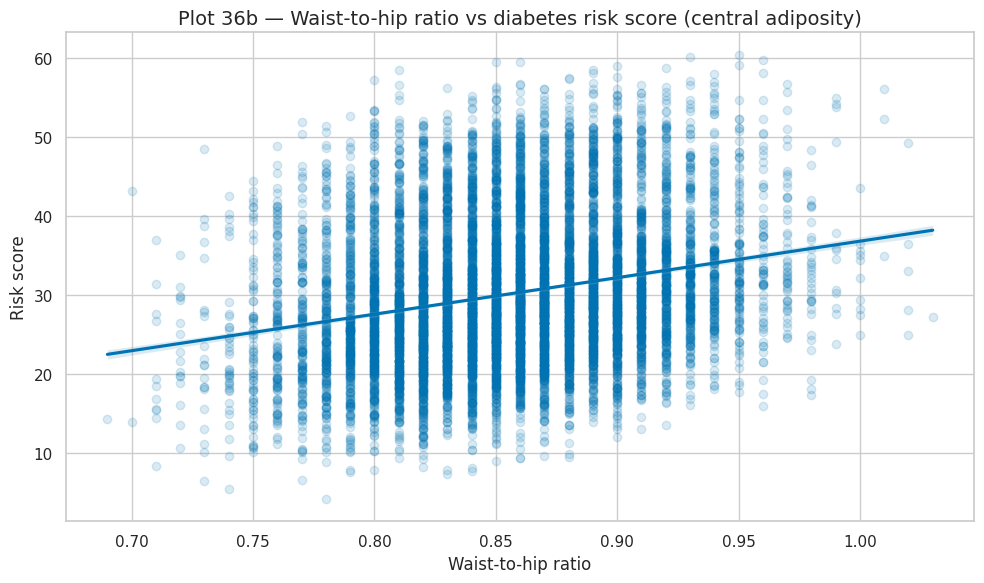

WHR can highlight central adiposity risk that BMI alone may not capture.


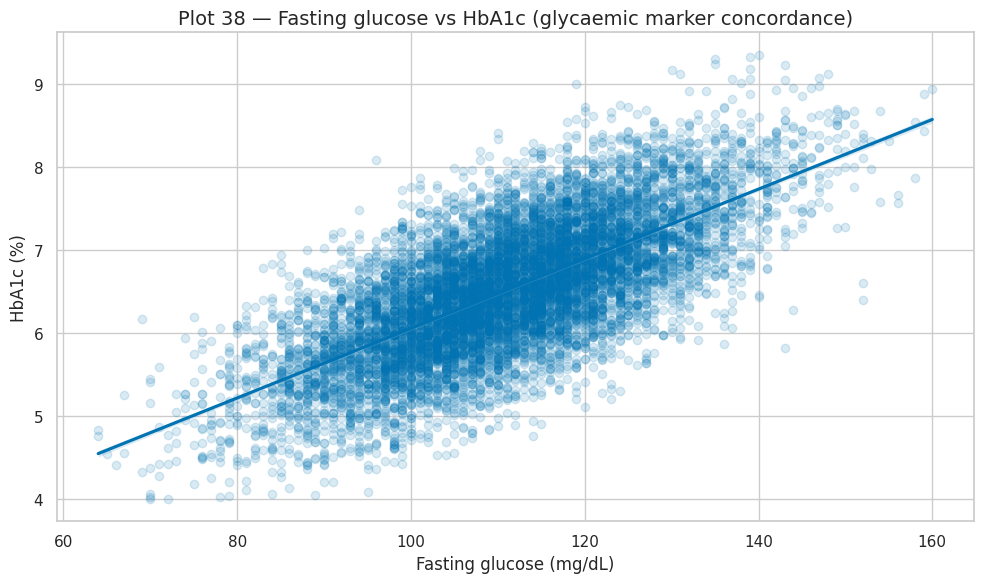

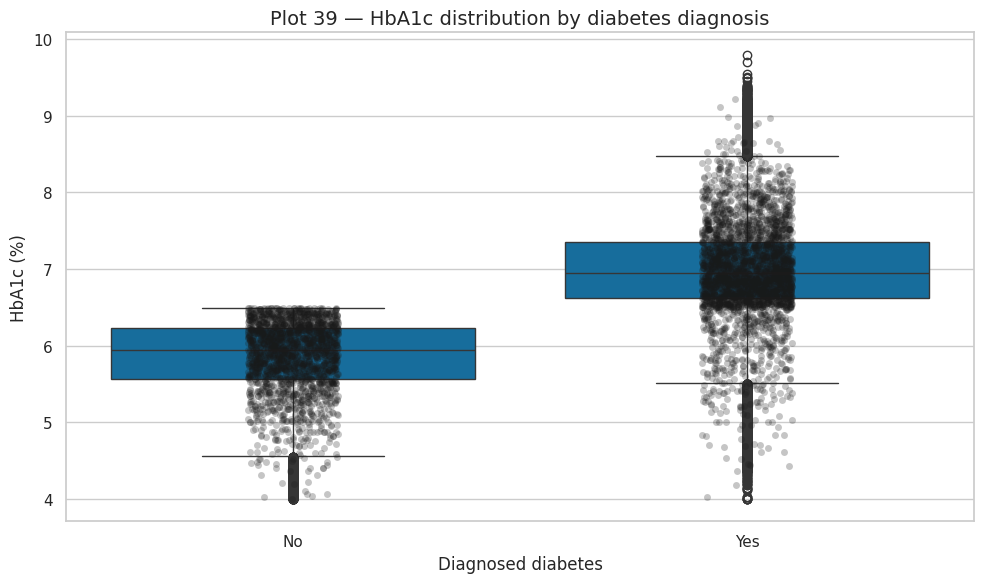

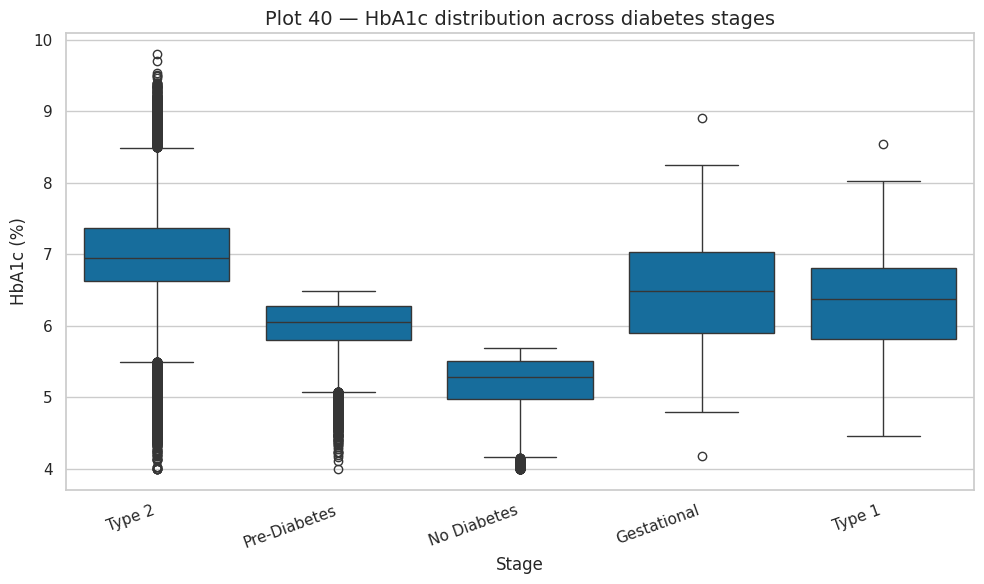

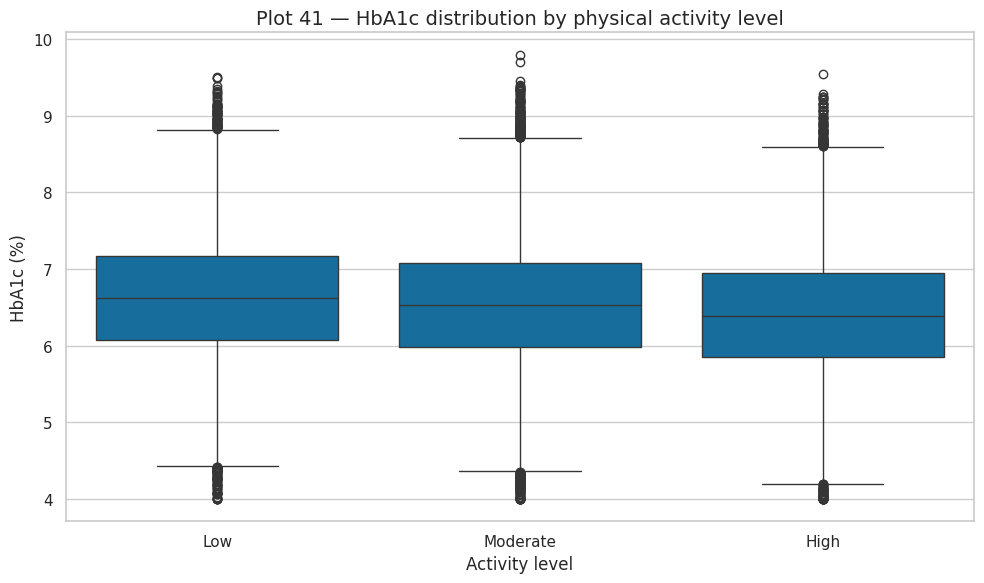

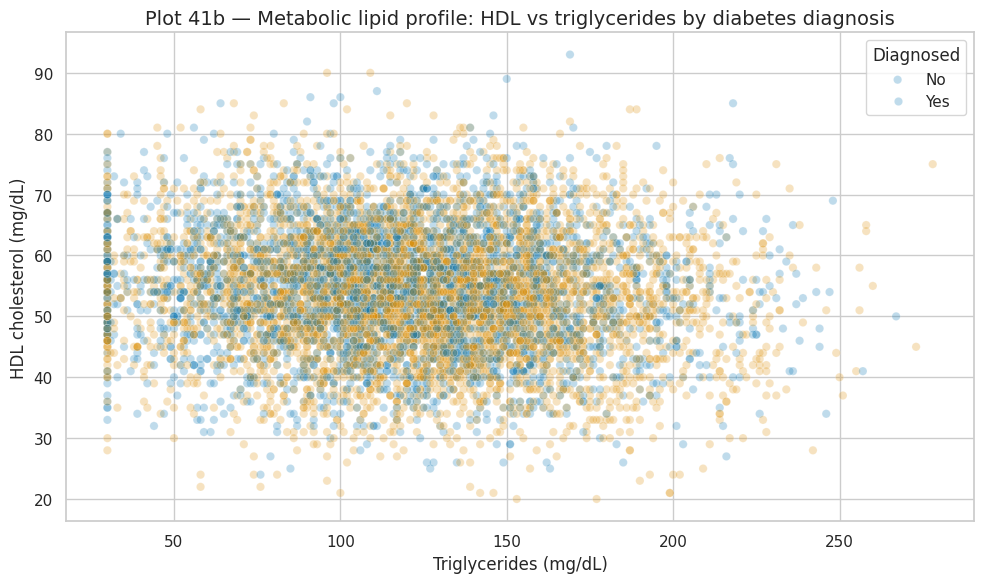

This supports a broader metabolic risk interpretation beyond glycaemic markers alone.


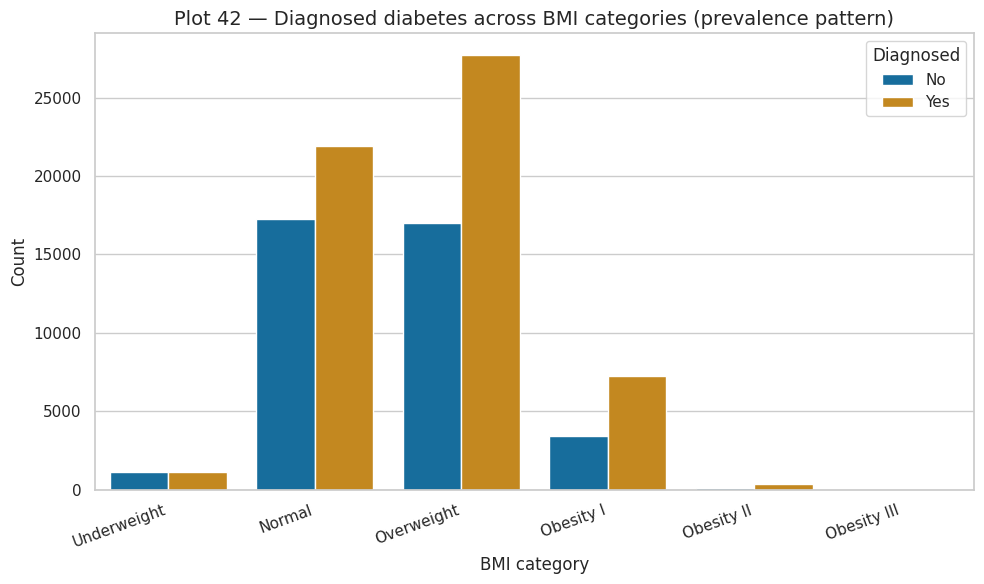

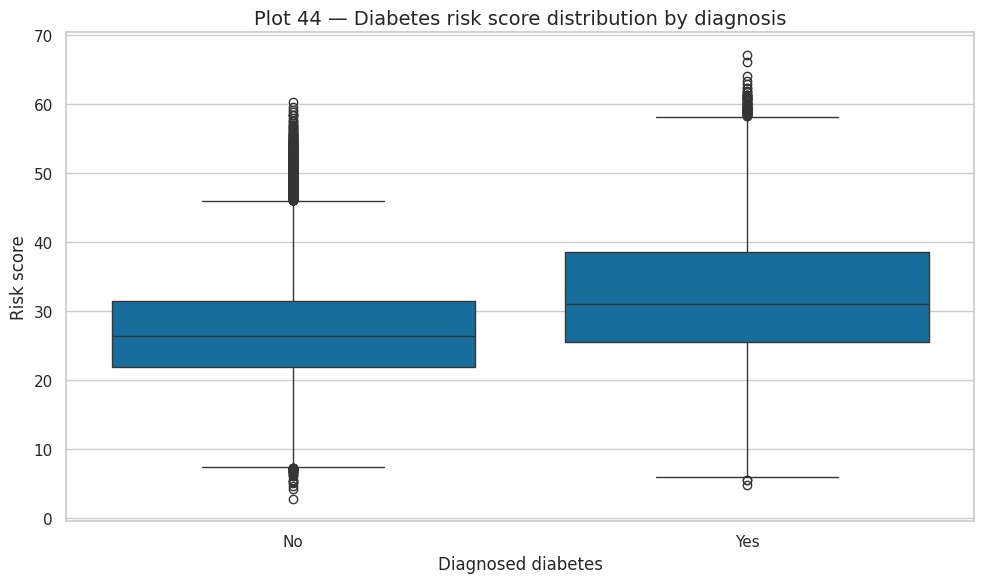

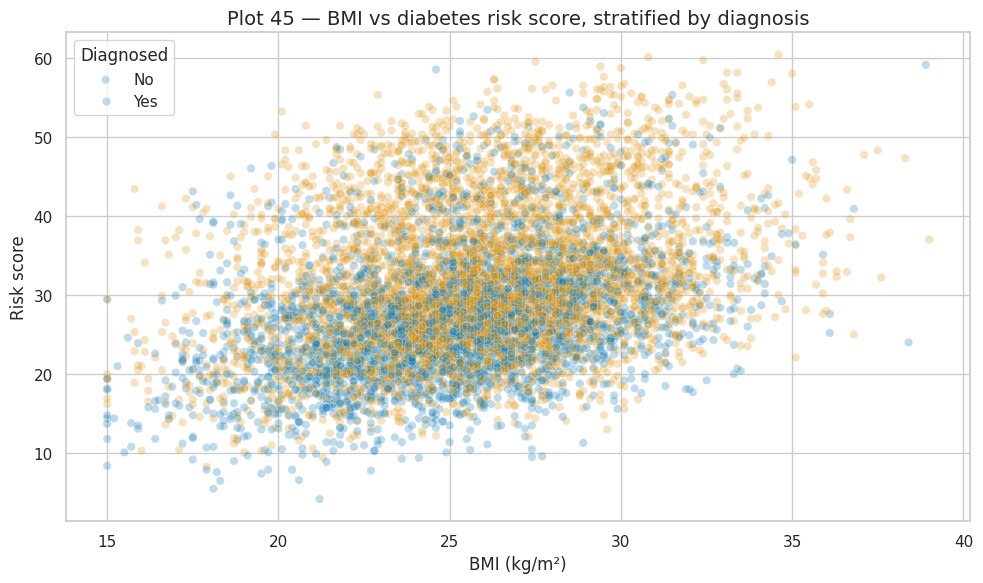

bmi_whr_profile  diagnosed_prevalence
0  Normal BMI / High WHR                  0.62
1                  Other                  0.59

BMI–WHR discordance suggests BMI-only thresholds can miss higher-risk central adiposity profiles.


In [75]:
# 13. Bivariate analysis (Plots 36–45)

# Plot 36a — Adiposity vs risk (BMI)
if {"bmi", "diabetes_risk_score"}.issubset(df_diab.columns):
    plt.figure()
    sns.regplot(
        data=df_diab.sample(min(10000, len(df_diab)), random_state=42),
        x="bmi", y="diabetes_risk_score",
        scatter_kws={"alpha":0.15}
    )
    plt.title("Plot 36a — BMI vs diabetes risk score (adiposity–risk association)")
    plt.xlabel("BMI (kg/m²)")
    plt.ylabel("Risk score")
    plt.show()

# Plot 36b — Central adiposity vs risk (WHR)
if {"waist_to_hip_ratio", "diabetes_risk_score"}.issubset(df_diab.columns):
    plt.figure()
    sns.regplot(
        data=df_diab.sample(min(10000, len(df_diab)), random_state=42),
        x="waist_to_hip_ratio", y="diabetes_risk_score",
        scatter_kws={"alpha":0.15}
    )
    plt.title("Plot 36b — Waist-to-hip ratio vs diabetes risk score (central adiposity)")
    plt.xlabel("Waist-to-hip ratio")
    plt.ylabel("Risk score")
    plt.show()

    print("WHR can highlight central adiposity risk that BMI alone may not capture.")

# Plot 37 — Age vs risk
if {"age", "diabetes_risk_score"}.issubset(df_diab.columns):
    plt.figure()
    sns.regplot(
        data=df_diab.sample(min(10000, len(df_diab)), random_state=42),
        x="age", y="diabetes_risk_score",
        scatter_kws={"alpha":0.15}
    )
    plt.title("Plot 37 — Age vs diabetes risk score (risk gradient across lifespan)")
    plt.xlabel("Age (years)")
    plt.ylabel("Risk score")
    plt.show()

# Plot 38 — Glycaemic linkage (fasting glucose vs HbA1c)
if {"glucose_fasting", "hba1c"}.issubset(df_diab.columns):
    plt.figure()
    sns.regplot(
        data=df_diab.sample(min(10000, len(df_diab)), random_state=42),
        x="glucose_fasting", y="hba1c",
        scatter_kws={"alpha":0.15}
    )
    plt.title("Plot 38 — Fasting glucose vs HbA1c (glycaemic marker concordance)")
    plt.xlabel("Fasting glucose (mg/dL)")
    plt.ylabel("HbA1c (%)")
    plt.show()

# Plot 39 — HbA1c by diagnosis (face validity check)
if {"diagnosed_diabetes", "hba1c"}.issubset(df_diab.columns):
    plt.figure()
    sns.boxplot(data=df_diab, x="diagnosed_diabetes", y="hba1c")
    sns.stripplot(
        data=df_diab.sample(min(5000, len(df_diab)), random_state=42),
        x="diagnosed_diabetes", y="hba1c",
        color="k", alpha=0.25, jitter=True
    )
    plt.title("Plot 39 — HbA1c distribution by diabetes diagnosis")
    plt.xlabel("Diagnosed diabetes")
    plt.ylabel("HbA1c (%)")
    plt.xticks([0, 1], ["No", "Yes"])
    plt.show()

# Plot 40 — HbA1c across diabetes stages
if {"diabetes_stage", "hba1c"}.issubset(df_diab.columns):
    plt.figure()
    sns.boxplot(
        data=df_diab, x="diabetes_stage", y="hba1c",
        order=df_diab["diabetes_stage"].value_counts().index
    )
    plt.title("Plot 40 — HbA1c distribution across diabetes stages")
    plt.xlabel("Stage")
    plt.ylabel("HbA1c (%)")
    nice_xticks(20)
    plt.show()

# Plot 41 — HbA1c by activity level
if {"activity_level", "hba1c"}.issubset(df_diab.columns):
    plt.figure()
    sns.boxplot(data=df_diab, x="activity_level", y="hba1c", order=["Low", "Moderate", "High"])
    plt.title("Plot 41 — HbA1c distribution by physical activity level")
    plt.xlabel("Activity level")
    plt.ylabel("HbA1c (%)")
    plt.show()

# Plot 41b — Lipid profile by diagnosis
if {"hdl_cholesterol", "triglycerides", "diagnosed_diabetes"}.issubset(df_diab.columns):
    s = df_diab.sample(min(8000, len(df_diab)), random_state=42)
    plt.figure()
    sns.scatterplot(
        data=s,
        x="triglycerides", y="hdl_cholesterol",
        hue="diagnosed_diabetes", alpha=0.25
    )
    plt.title("Plot 41b — Metabolic lipid profile: HDL vs triglycerides by diabetes diagnosis")
    plt.xlabel("Triglycerides (mg/dL)")
    plt.ylabel("HDL cholesterol (mg/dL)")
    plt.legend(title="Diagnosed", labels=["No", "Yes"])
    plt.show()

    print("This supports a broader metabolic risk interpretation beyond glycaemic markers alone.")

# Plot 42 — Diagnosis prevalence across BMI categories
if {"bmi_category", "diagnosed_diabetes"}.issubset(df_diab.columns):
    plt.figure()
    sns.countplot(
        data=df_diab, x="bmi_category", hue="diagnosed_diabetes",
        order=["Underweight", "Normal", "Overweight", "Obesity I", "Obesity II", "Obesity III"]
    )
    plt.title("Plot 42 — Diagnosed diabetes across BMI categories (prevalence pattern)")
    plt.xlabel("BMI category")
    plt.ylabel("Count")
    nice_xticks(20)
    plt.legend(title="Diagnosed", labels=["No", "Yes"])
    plt.show()

# Plot 43 — Diagnosed diabetes prevalence by age band
if {"age_band", "diagnosed_diabetes"}.issubset(df_diab.columns):
    prev_age = df_diab.groupby("age_band")["diagnosed_diabetes"].mean().reset_index()
    plt.figure()
    sns.barplot(data=prev_age, x="age_band", y="diagnosed_diabetes")
    plt.title("Plot 43 — Diagnosed diabetes prevalence by age band")
    plt.xlabel("Age band")
    plt.ylabel("Proportion diagnosed")
    plt.ylim(0, 1)
    plt.show()

# Plot 44 — Risk score by diagnosis
if {"diagnosed_diabetes", "diabetes_risk_score"}.issubset(df_diab.columns):
    plt.figure()
    sns.boxplot(data=df_diab, x="diagnosed_diabetes", y="diabetes_risk_score")
    plt.title("Plot 44 — Diabetes risk score distribution by diagnosis")
    plt.xlabel("Diagnosed diabetes")
    plt.ylabel("Risk score")
    plt.xticks([0, 1], ["No", "Yes"])
    plt.show()

# Plot 45 — BMI vs risk score, stratified by diagnosis
if {"bmi", "diabetes_risk_score", "diagnosed_diabetes"}.issubset(df_diab.columns):
    s = df_diab.sample(min(8000, len(df_diab)), random_state=42)
    plt.figure()
    sns.scatterplot(data=s, x="bmi", y="diabetes_risk_score", hue="diagnosed_diabetes", alpha=0.25)
    plt.title("Plot 45 — BMI vs diabetes risk score, stratified by diagnosis")
    plt.xlabel("BMI (kg/m²)")
    plt.ylabel("Risk score")
    plt.legend(title="Diagnosed", labels=["No", "Yes"])
    plt.show()

# BMI–WHR discordance: temporary segmentation (not a stored feature)
if {"bmi", "waist_to_hip_ratio", "diagnosed_diabetes"}.issubset(df_diab.columns):
    bmi_whr_profile = np.where(
        (df_diab["bmi"] < 30) & (df_diab["waist_to_hip_ratio"] > df_diab["waist_to_hip_ratio"].median()),
        "Normal BMI / High WHR",
        "Other"
    )

    prev = (
        pd.DataFrame({
            "bmi_whr_profile": bmi_whr_profile,
            "diagnosed_diabetes": df_diab["diagnosed_diabetes"]
        })
        .groupby("bmi_whr_profile")["diagnosed_diabetes"]
        .mean()
        .reset_index()
        .rename(columns={"diagnosed_diabetes": "diagnosed_prevalence"})
    )

    display(prev)
    print("BMI–WHR discordance suggests BMI-only thresholds can miss higher-risk central adiposity profiles.")

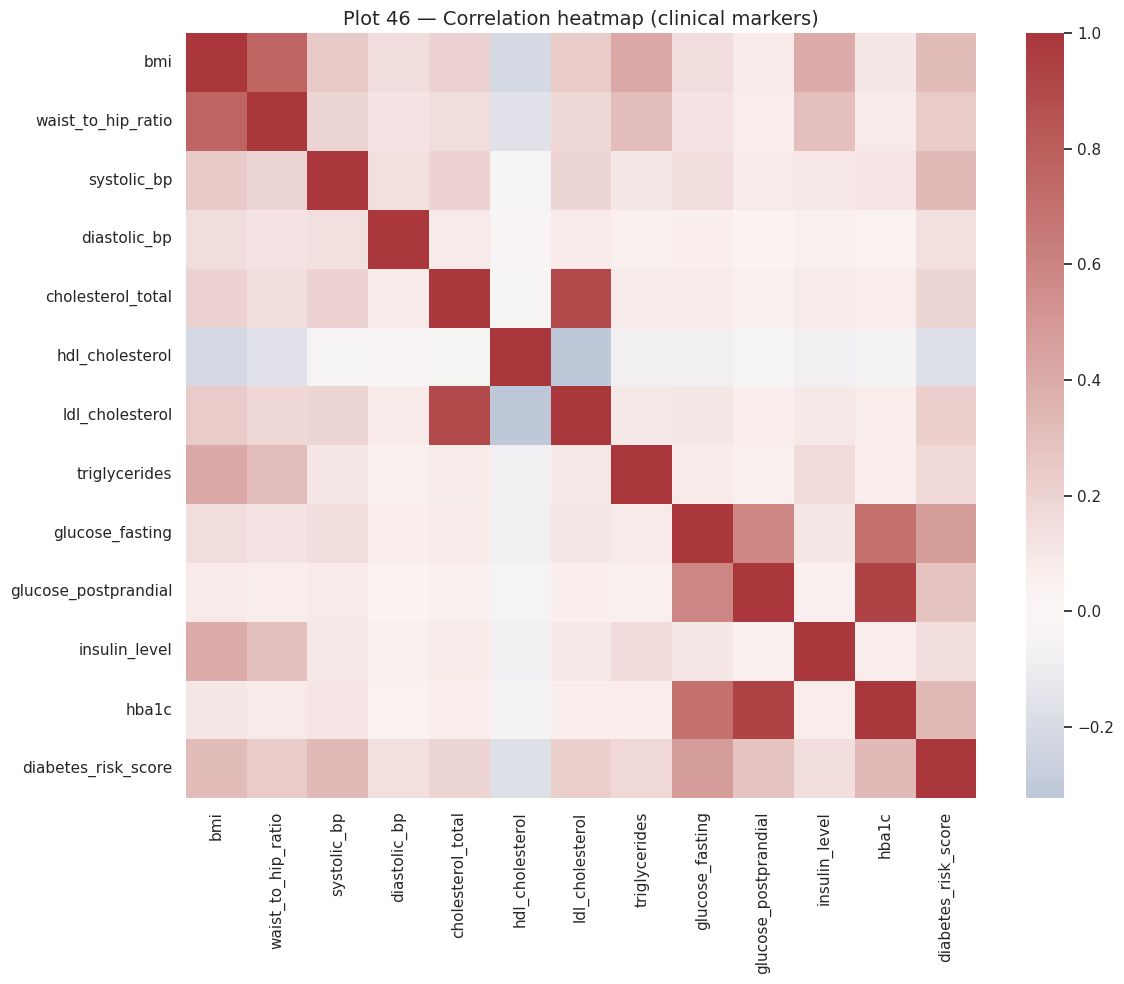

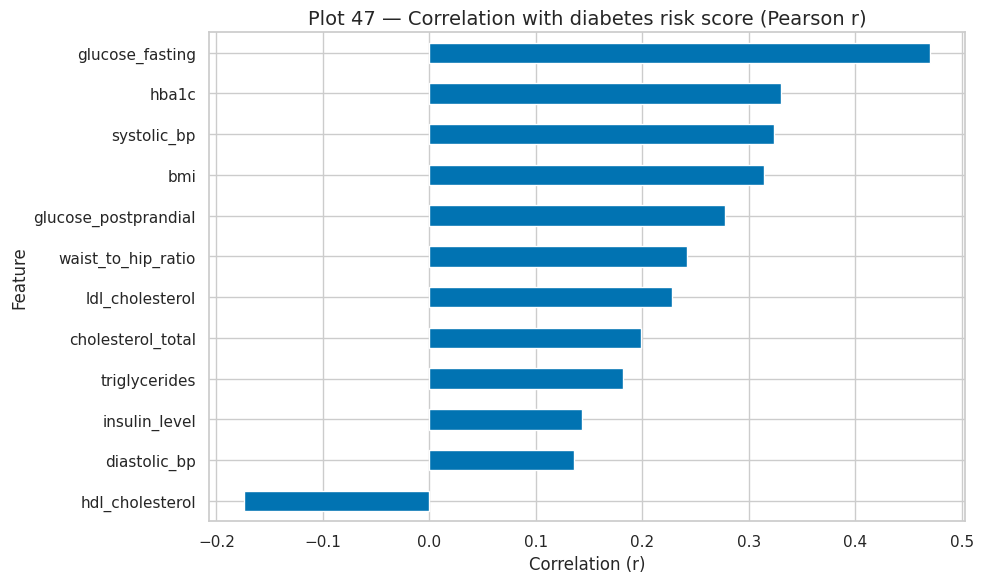

In [76]:
# 14. Correlation structure (Plots 46–47)

clinical_cols = [c for c in [
    "age","bmi","waist_to_hip_ratio",
    "systolic_bp","diastolic_bp",
    "cholesterol_total","hdl_cholesterol","ldl_cholesterol",
    "triglycerides",
    "glucose_fasting","glucose_postprandial",
    "insulin_level","hba1c","diabetes_risk_score"
] if c in df_diab.columns]

if len(clinical_cols) >= 5:
    corr_heatmap(df_diab, clinical_cols, "Plot 46 — Correlation heatmap (clinical markers)")

    # Plot 47: pairwise correlations with risk score (bar)
    if "diabetes_risk_score" in clinical_cols:
        corr_rs = df_diab[clinical_cols].corr()["diabetes_risk_score"].drop("diabetes_risk_score").sort_values()
        plt.figure(figsize=(10, 6))
        corr_rs.plot(kind="barh")
        plt.title("Plot 47 — Correlation with diabetes risk score (Pearson r)")
        plt.xlabel("Correlation (r)")
        plt.ylabel("Feature")
        plt.show()

# Part C — Hypothesis testing & regression diagnostics (inferential layer)

Visual evidence is not enough. For selected relationships, this section:
- fits a regression model,
- tests **H₀: slope = 0**,
- reports **confidence intervals**,
- checks assumptions (residual diagnostics),
- uses **Breusch–Pagan** and **HC3 robust standard errors** when needed.

                            OLS Regression Results                            
Dep. Variable:                  hba1c   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                 9.365e+04
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:57:25   Log-Likelihood:                -85199.
No. Observations:               97297   AIC:                         1.704e+05
Df Residuals:                   97295   BIC:                         1.704e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.8608      0.015    1

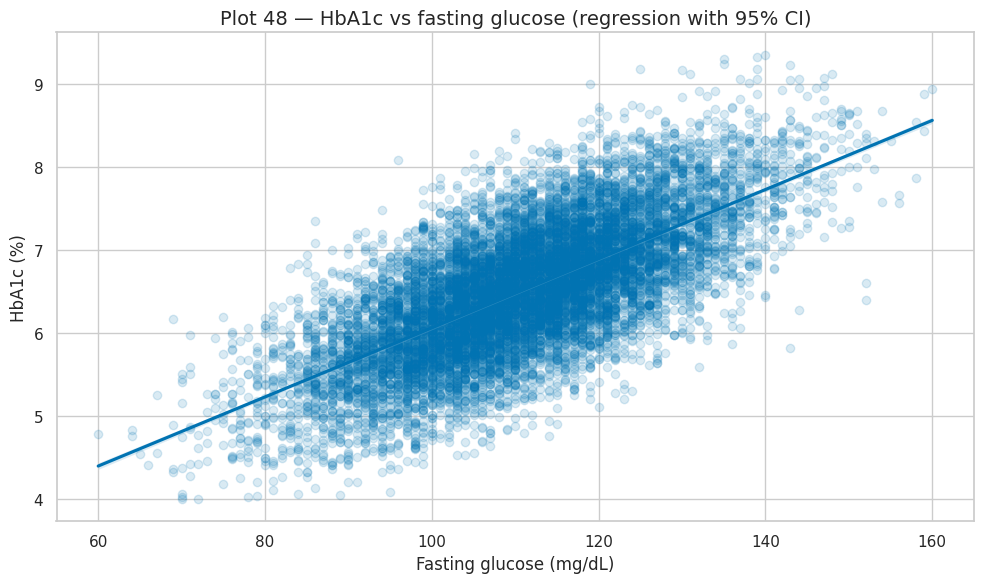

Slope: 0.0419 | p-value: 0.000e+00 | 95% CI: [0.0417, 0.0422] | R²: 0.490


LM stat      0.29
LM p-value   0.59
F stat       0.29
F p-value    0.59
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                  hba1c   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                 9.508e+04
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:57:26   Log-Likelihood:                -85199.
No. Observations:               97297   AIC:                         1.704e+05
Df Residuals:                   97295   BIC:                         1.704e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.8608      0.015    1

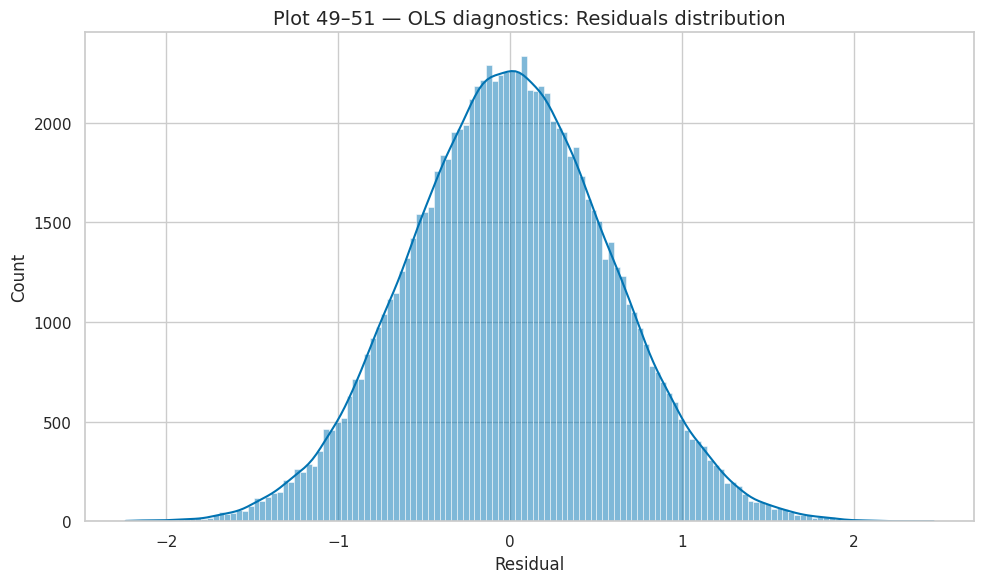

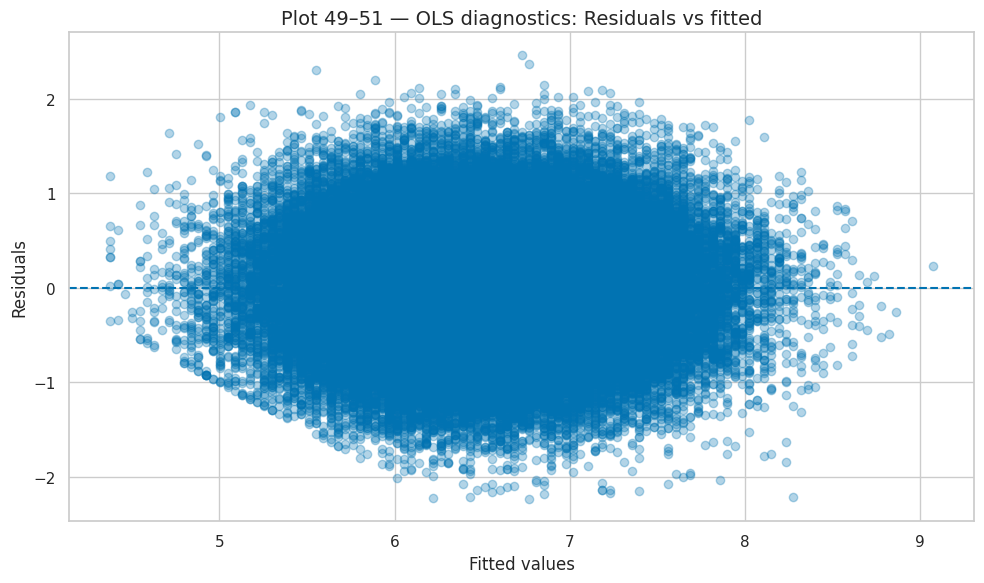

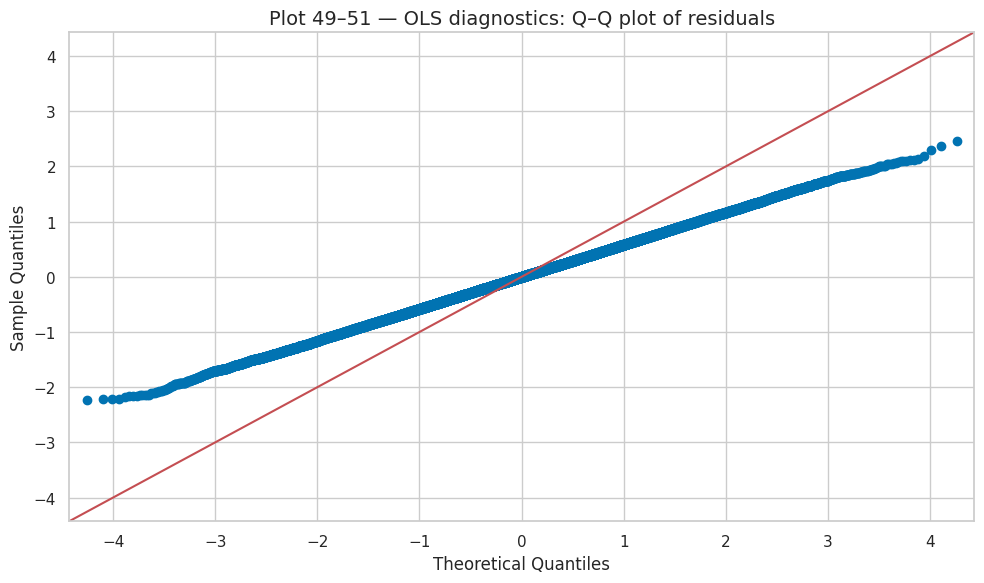

coef  se_classic  se_robust  p_classic  p_robust
const            1.86        0.02       0.02       0.00      0.00
glucose_fasting  0.04        0.00       0.00       0.00      0.00

In [77]:
# 15. OLS example: HbA1c ~ fasting glucose (Plots 48–52)

if {"glucose_fasting", "hba1c"}.issubset(df_diab.columns):
    # Fit OLS
    m = ols_fit(df_diab["hba1c"], df_diab[["glucose_fasting"]])

    print(m.summary())

    # Plot 48: scatter + regression line
    plt.figure()
    sns.regplot(data=df_diab.sample(min(12000, len(df_diab)), random_state=42),
                x="glucose_fasting", y="hba1c", scatter_kws={"alpha":0.15})
    plt.title("Plot 48 — HbA1c vs fasting glucose (regression with 95% CI)")
    plt.xlabel("Fasting glucose (mg/dL)")
    plt.ylabel("HbA1c (%)")
    plt.show()

    # Extract slope + CI
    slope = m.params["glucose_fasting"]
    pval = m.pvalues["glucose_fasting"]
    ci = m.conf_int().loc["glucose_fasting"]
    print(f"Slope: {slope:.4f} | p-value: {pval:.3e} | 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}] | R²: {m.rsquared:.3f}")

    # Breusch–Pagan
    bp = breusch_pagan_test(m)
    display(bp)

    # Robust SE (HC3)
    m_robust = m.get_robustcov_results(cov_type="HC3")
    print(m_robust.summary())

    # Plots 49–51 diagnostics
    regression_diagnostics(m, title_prefix="Plot 49–51 — OLS diagnostics:")

    # Plot 52: compare classic vs robust p-values
    comp = pd.DataFrame({
        "coef": m.params,
        "se_classic": m.bse,
        "se_robust": m_robust.bse,
        "p_classic": m.pvalues,
        "p_robust": m_robust.pvalues
    })
    display(comp)

### Interpreting p-values and confidence intervals (brief)

- The p-value is **not** the probability that the null hypothesis is true.  
  It is the probability of observing an effect at least this extreme **if** the true slope were 0.
- The confidence interval is often more useful than the p-value because it communicates:
  - effect size,
  - precision,
  - plausibility range.

Welch t-test | t = 306.64 | p = 0.000e+00


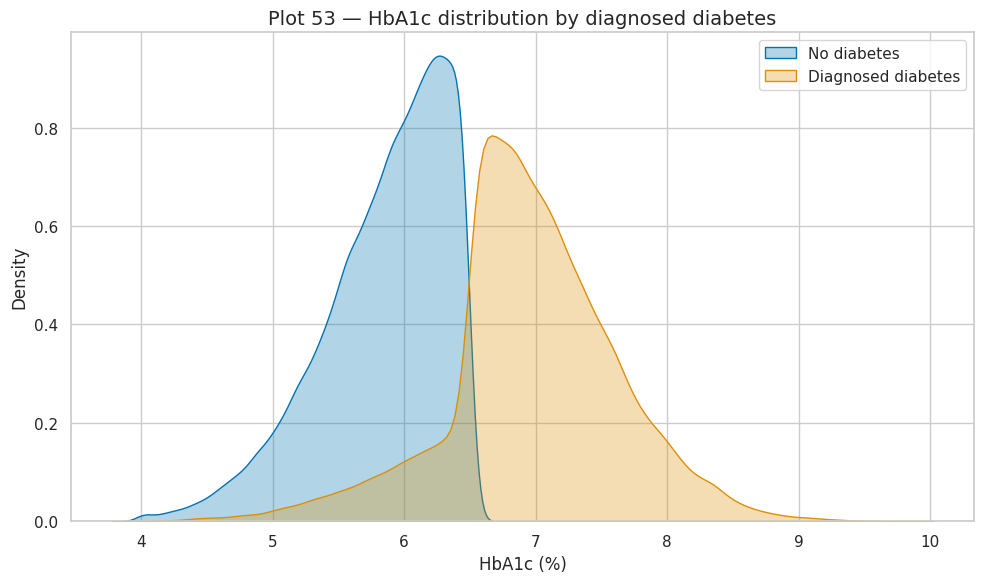

In [78]:
# 16. Hypothesis test example: HbA1c in diagnosed vs not diagnosed (Plot 53)

if {"diagnosed_diabetes", "hba1c"}.issubset(df_diab.columns):
    g1 = df_diab.loc[df_diab["diagnosed_diabetes"]==1, "hba1c"]
    g0 = df_diab.loc[df_diab["diagnosed_diabetes"]==0, "hba1c"]

    t_stat, p_value = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"Welch t-test | t = {t_stat:.2f} | p = {p_value:.3e}")

    plt.figure()
    sns.kdeplot(g0, label="No diabetes", fill=True, alpha=0.3)
    sns.kdeplot(g1, label="Diagnosed diabetes", fill=True, alpha=0.3)
    plt.title("Plot 53 — HbA1c distribution by diagnosed diabetes")
    plt.xlabel("HbA1c (%)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Part D — Supervised learning (prediction-focused)

This section shifts from inference to prediction:
- Multiple linear regression to predict `diabetes_risk_score`.
- Logistic regression to model `diagnosed_diabetes`.

Even here, model diagnostics and interpretability remain important.

Multiple Linear Regression — diabetes_risk_score
Features: ['bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'cholesterol_total', 'triglycerides', 'glucose_fasting', 'hba1c']
MSE: 54.04 | RMSE: 7.35 | MAE: 5.84 | MaxAE: 29.32
R²: 0.337 | Adjusted R²: 0.337 | MAPE: 21.01%


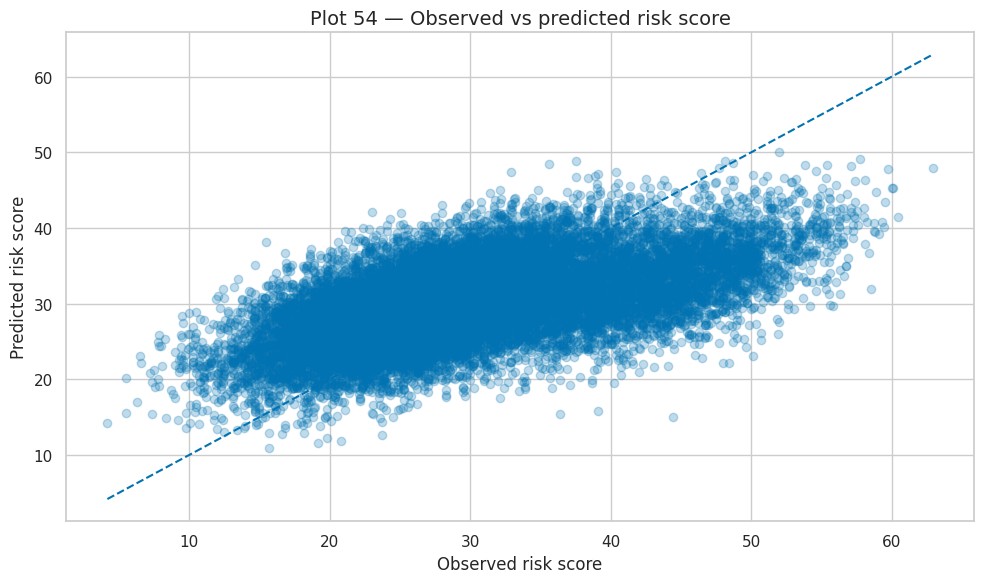

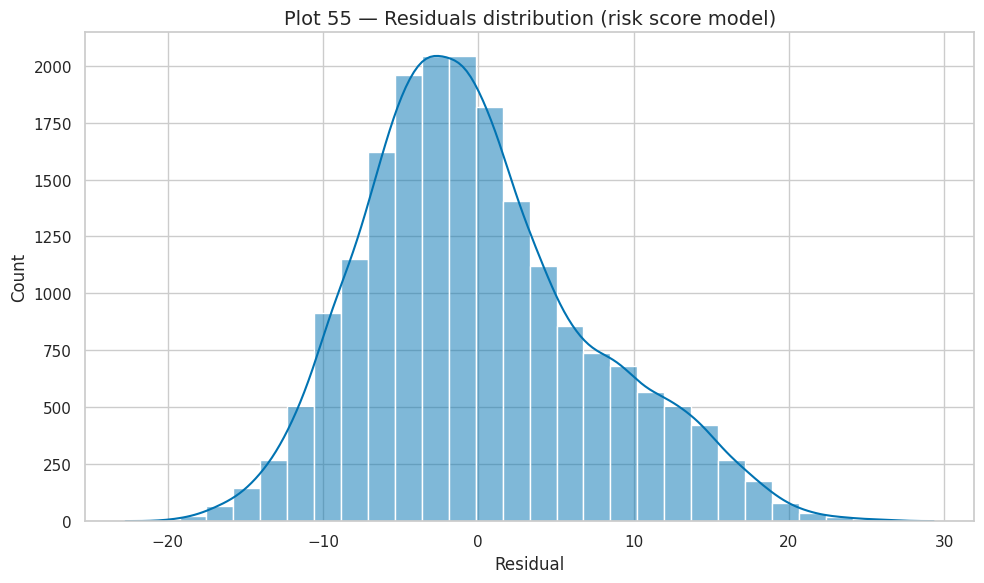

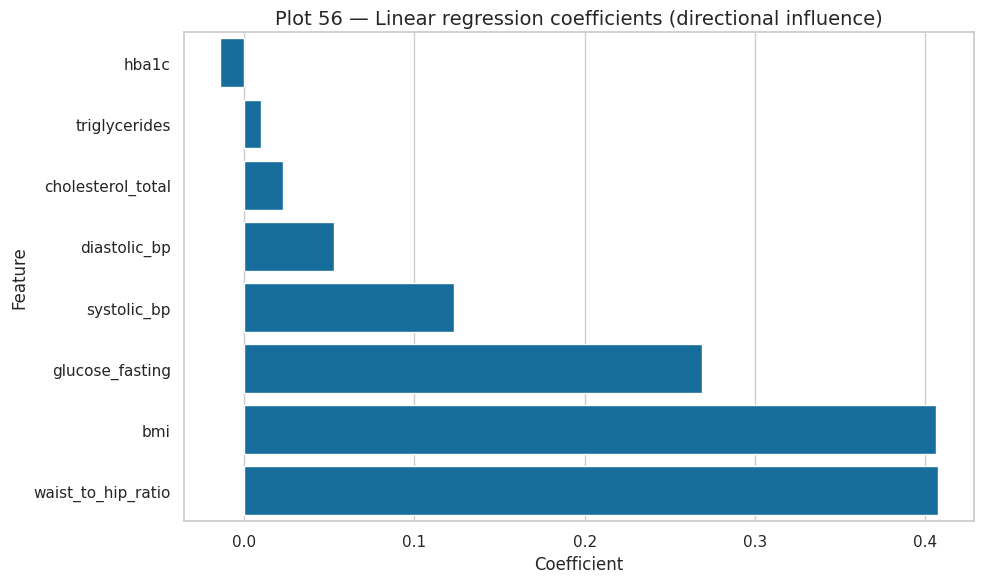

In [79]:
# 17. Multiple Linear Regression (sklearn) — predict diabetes_risk_score (Plots 54–56)

target = "diabetes_risk_score"
candidate_features = [
    "age","bmi","waist_to_hip_ratio",
    "systolic_bp","diastolic_bp",
    "cholesterol_total","triglycerides",
    "glucose_fasting","hba1c"
]
features = [f for f in candidate_features if f in df_diab.columns]

if target in df_diab.columns and len(features) >= 2:
    X = df_diab[features].copy()
    y = df_diab[target].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    max_abs_error = np.max(np.abs(y_test - y_pred))
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_test.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print("Multiple Linear Regression — diabetes_risk_score")
    print("Features:", features)
    print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MaxAE: {max_abs_error:.2f}")
    print(f"R²: {r2:.3f} | Adjusted R²: {r2_adj:.3f} | MAPE: {mape:.2f}%")

    # Plot 54: observed vs predicted
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.25)
    lo, hi = y_test.min(), y_test.max()
    plt.plot([lo, hi], [lo, hi], linestyle="--")
    plt.title("Plot 54 — Observed vs predicted risk score")
    plt.xlabel("Observed risk score")
    plt.ylabel("Predicted risk score")
    plt.show()

    # Plot 55: residual distribution
    resid = y_test - y_pred
    plt.figure()
    sns.histplot(resid, kde=True, bins=30)
    plt.title("Plot 55 — Residuals distribution (risk score model)")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.show()

    # Plot 56: feature importance (coefficients)
    coef_df = pd.DataFrame({"feature": features, "coef": linreg.coef_}).sort_values("coef")
    plt.figure()
    sns.barplot(data=coef_df, x="coef", y="feature")
    plt.title("Plot 56 — Linear regression coefficients (directional influence)")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.show()

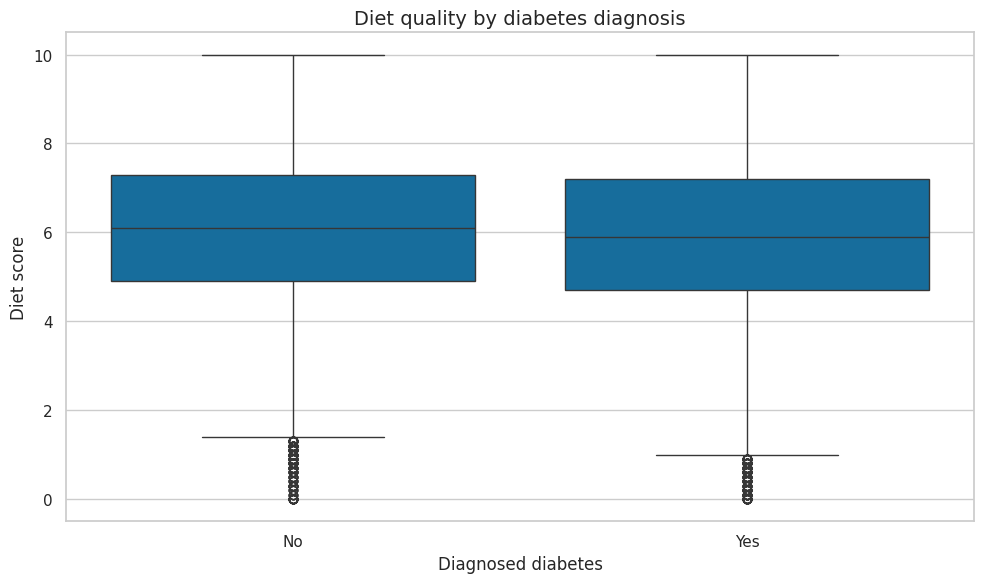

Lifestyle variables retain explanatory power and help contextualise pharmacological response.


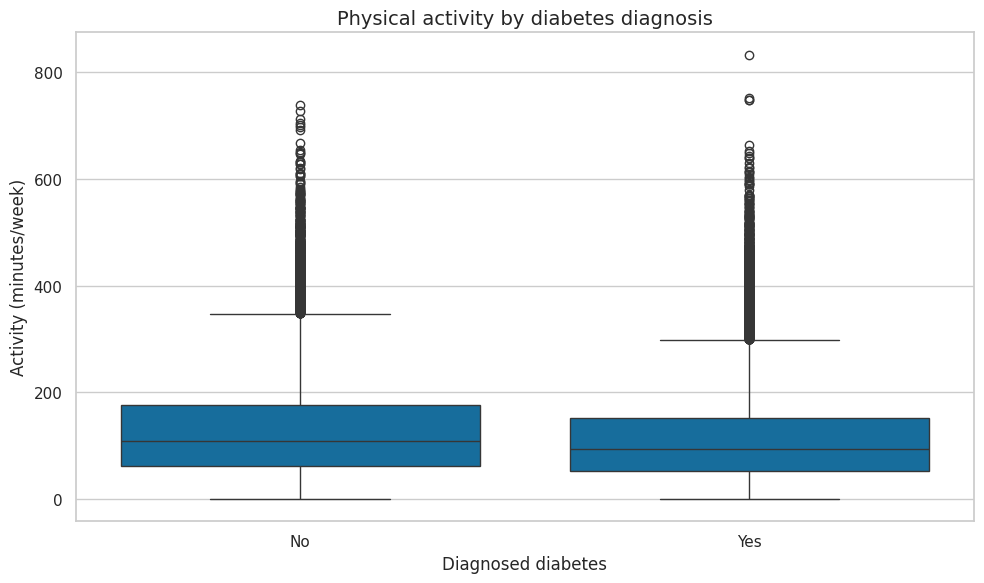

In [80]:
# Diet quality by diabetes diagnosis (behavioural context before modelling)
if {"diet_score", "diagnosed_diabetes"}.issubset(df_diab.columns):
    plt.figure()
    sns.boxplot(data=df_diab, x="diagnosed_diabetes", y="diet_score")
    plt.title("Diet quality by diabetes diagnosis")
    plt.xlabel("Diagnosed diabetes")
    plt.ylabel("Diet score")
    plt.xticks([0,1], ["No", "Yes"])
    plt.show()

    print("Lifestyle variables retain explanatory power and help contextualise pharmacological response.")

if {"physical_activity_minutes_per_week", "diagnosed_diabetes"}.issubset(df_diab.columns):
    plt.figure()
    sns.boxplot(data=df_diab, x="diagnosed_diabetes", y="physical_activity_minutes_per_week")
    plt.title("Physical activity by diabetes diagnosis")
    plt.xlabel("Diagnosed diabetes")
    plt.ylabel("Activity (minutes/week)")
    plt.xticks([0,1], ["No", "Yes"])
    plt.show()

# 18. Logistic regression (statsmodels) — diagnosed_diabetes (Plots 57–58)

logit_cols = [
    "diagnosed_diabetes",
    "age","bmi",
    "family_history_diabetes","hypertension_history",
    "physical_activity_minutes_per_week","diet_score"
]

if set(logit_cols).issubset(df_diab.columns):
    logit_df = df_diab[logit_cols].dropna().copy()

    # Standardise continuous predictors
    for col in ["age","bmi","physical_activity_minutes_per_week","diet_score"]:
        logit_df[col + "_z"] = (logit_df[col] - logit_df[col].mean()) / logit_df[col].std()

    formula = (
        "diagnosed_diabetes ~ age_z + bmi_z + family_history_diabetes + "
        "hypertension_history + physical_activity_minutes_per_week_z + diet_score_z"
    )

    logit_model = smf.logit(formula=formula, data=logit_df).fit(disp=False)
    print(logit_model.summary())

    # Odds ratios
    params = logit_model.params
    conf = logit_model.conf_int()
    or_table = pd.DataFrame({
        "OR": np.exp(params),
        "CI_lower": np.exp(conf[0]),
        "CI_upper": np.exp(conf[1])
    }).sort_values("OR", ascending=False)

    display(or_table)

    # Plot 57: odds ratios (log scale for readability)
    or_plot = or_table.reset_index().rename(columns={"index":"term"})
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        x=or_plot["OR"],
        y=np.arange(len(or_plot)),
        xerr=[or_plot["OR"] - or_plot["CI_lower"], or_plot["CI_upper"] - or_plot["OR"]],
        fmt="o"
    )
    plt.yticks(np.arange(len(or_plot)), or_plot["term"])
    plt.xscale("log")
    plt.axvline(1, linestyle="--")
    plt.title("Plot 57 — Logistic regression odds ratios (log scale) with 95% CI")
    plt.xlabel("Odds ratio (log scale)")
    plt.ylabel("")
    plt.show()

    # Plot 58: predicted probability vs BMI_z (holding others at mean)
    grid = logit_df.copy()
    grid["bmi_z"] = np.linspace(logit_df["bmi_z"].min(), logit_df["bmi_z"].max(), 200)
    for c in ["age_z","physical_activity_minutes_per_week_z","diet_score_z"]:
        grid[c] = 0
    for c in ["family_history_diabetes","hypertension_history"]:
        grid[c] = logit_df[c].mode()[0]

    grid["pred_prob"] = logit_model.predict(grid)

    plt.figure()
    plt.plot(grid["bmi_z"], grid["pred_prob"])
    plt.title("Plot 58 — Predicted probability of diagnosed diabetes vs BMI (z-score)")
    plt.xlabel("BMI (z-score)")
    plt.ylabel("Predicted probability")
    plt.ylim(0, 1)
    plt.show()

# Part E — Linking both datasets (conceptual integration)

The datasets cannot be joined at the individual level (different granularity).  
Instead, they are linked as two layers of the same public health story:
- **patient-level metabolic risk profile** (diabetes dataset),
- **system-level pharmacological response** (dispensing dataset).

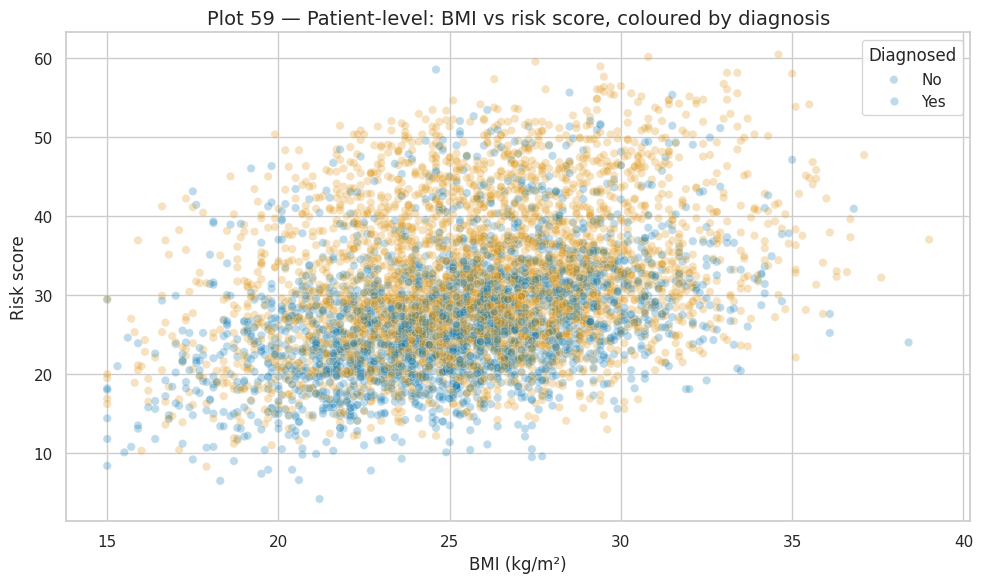

In [81]:
# Risk score by age band (mean) — contextual bridge to dispensing trends
if {"age_band", "diabetes_risk_score"}.issubset(df_diab.columns):
    age_risk = (
        df_diab.groupby("age_band")["diabetes_risk_score"]
        .mean()
        .reset_index()
        .rename(columns={"diabetes_risk_score": "mean_risk_score"})
    )
    display(age_risk)
    print("Age bands with higher average risk can help contextualise system-level GLP-1 uptake over time.")

# 19. One compact integration visual (Plot 59)

if {"bmi","diabetes_risk_score","diagnosed_diabetes"}.issubset(df_diab.columns):
    s = df_diab.sample(min(6000, len(df_diab)), random_state=42)

    plt.figure()
    sns.scatterplot(data=s, x="bmi", y="diabetes_risk_score", hue="diagnosed_diabetes", alpha=0.25)
    plt.title("Plot 59 — Patient-level: BMI vs risk score, coloured by diagnosis")
    plt.xlabel("BMI (kg/m²)")
    plt.ylabel("Risk score")
    plt.legend(title="Diagnosed", labels=["No","Yes"])
    plt.show()

# Why this notebook does NOT make causal claims

This notebook reports **associations**, not causes.

Reasons:
- The diabetes dataset is **synthetic** and cross-sectional in nature.
- The dispensing dataset is an **aggregate time series** without patient linkage.
- Even with statistically significant relationships:
  - confounding variables may exist,
  - reverse causation may be possible,
  - selection effects may distort associations.

Causal inference typically requires:
- explicit causal assumptions (DAGs),
- richer longitudinal or linked data,
- and designs such as randomized trials, quasi-experiments, or robust causal estimators.

Therefore, conclusions are framed as:
- “is associated with”
- “is consistent with”
- “may reflect”
rather than “causes”.

# Executive summary
**Scope:** two independent datasets (synthetic patient-level risk + NHS aggregated dispensing). Findings are associative; no patient-level linkage.

- **Dispensing (2019–2023):** clear growth over time with molecule-specific trajectories. Trend slopes estimated via OLS; heteroscedasticity checked (Breusch–Pagan) and HC3 robust SE used when needed.
- **Risk profile:** diabetes prevalence rises across age bands and BMI categories; glycaemic markers show expected concordance (fasting glucose vs HbA1c).
- **Added clinical signal:** WHR highlights central adiposity risk beyond BMI, and a simple BMI–WHR discordance split flags a subgroup potentially under-captured by BMI thresholds.
- **Metabolic + behavioural context:** HDL–TG patterns support broader metabolic risk framing; diet and physical activity remain informative alongside clinical markers.
- **Models:** linear regression for risk score and logistic regression for diagnosis provide interpretable associations (coefficients/odds ratios).

**Overall, the analysis confirms clinically expected patterns while demonstrating
a rigorous, reproducible analytical workflow rather than seeking novel clinical claims.**